# Inside AirBnB

## Enunciado

Este Notebook consiste en la actividad evaluable correspondiente al Módulo 1 de la Asignatura de Aprendizaje Automático I del Máster en Ingeniería y Ciencia de Datos de la UNED.

La actividad constituye en un ejercicio de clasificación empleando los tres métodos descritos en el tema y la aplicación de varias de las técnicas estudiadas en el Tema 2.

### 1. Datos

Los datos provienen de la web InsideAirBnB, dedicada al estudio de los alquileres vacacionales ofrecidos en la plataforma AirBnB. El fichero está contenido dentro de la carpeta datasets/insideAirBnB. Este fichero es una versión editada, a fin de facilitar la tarea, del listado original de información sobre las ofertas existentes, para la ciudad de Madrid, en abril de 2017. 

> Contiene 13321 registros con 11 campos cada uno, correspondientes a diferentes características de cada oferta de alojamiento.

La tarea de clasificación consistirá en clasificar los datos según el tipo de alojamiento, definido en el campo room_type, a partir del resto de características. Es decir, en room_type estarán codificadas las clases y en el resto de campos los atributos.

### 2. Estudio estadístico y limpieza de datos

Se realizará un breve estudio estadístico de los datos numéricos y de la variable `room_type` se contarán los valores de cada clase. Si las clases no estuvieran balanceadas habrá que usar los mecanismos que puedan tener los algoritmos de clasificación para tratar con este caso. Para Naive Bayes ya se habla de esto en la actividades autoevaluables, para los otros métodos consultar en la documentación de sus APIs los parámetros de los constructores para ver si hay mecanismos para balancear.
En cuanto a la limpieza de datos estudiar si hay datos faltantes, transformar datos categóricos y escalar datos numéricos haciendo uso de pipelines cuando sea posible.

### 3. Entrenamiento y validación

1. Dividir los datos en conjunto de entrenamiento y test de manera que el conjunto de test sea un 20 % del total.
2. Evaluar los modelos midiendo la exactitud (accuracy) usando validación cruzada para los tres métodos estudiados utilizando los parámetros por defecto de los tres métodos, salvo lo comentado para el balance, para cross_val_score usar cv=10. Comparar los resultados de los tres modelos.
3. Realizar la afinación de hiperparámetros para KNN y Árboles de decisión empleando Grid- SearchCV, Naive Bayes no tiene hiperparámetros que afinar.
    1. Para KNN buscando el valor óptimo de K.
    2. Para Árboles de decisión: variando max_leaf_nodes entre 2 y 50 ambos inclusive , min_samples_split entre 2 y 6 ambos inclusive y max_depth entre 1 y 20 ambos in- clusive. Ver la documentación de la API.

### 4. Valoración

Se valorará la creación del código que realice los requisitos enumerados, la presencia de comentarios de lo que hace el código y sus resultados y las comparaciones entre los resultados obtenidos por los distintos algoritmos, así como algún gráfico que muestre los resultados. Para terminar incluir un apartado de conclusiones. Tanto los comentarios como las conclusiones no es necesario que sea extensos, sino que describan de forma concisa.

# Objetivo:
Crear un modelo, que dado unos datos prediga el room_type al que pertence.

In [20]:
! pwd

/Users/adzarei/Documents/UNED/ING_CIENC_DATOS/projects/AAI/TP1


In [73]:
import os
import joblib
import pandas as pd
import numpy as np
import operator
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix

# Requiere la instalación de pandasprofiling:
# COMANDO: conda install pandas-profiling
import pandas_profiling

### Recogida de datos

En primer lugar, vamos a cargar los datos con los que vamos a trabajar. En mi caso los datos están en la carpeta datasets/insideAirBnB que está ubicada en un nivel superior a la carpeta de trabajo. Modificar esta ruta si es necesario.

In [22]:
data_path = os.path.join("..","datasets","insideAirBnB","airbnb.csv")
airbnb = pd.read_csv(data_path)

In [23]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
neighbourhood_group               13321 non-null object
neighbourhood                     13321 non-null object
latitude                          13321 non-null float64
longitude                         13321 non-null float64
room_type                         13321 non-null object
price                             13321 non-null int64
minimum_nights                    13321 non-null int64
number_of_reviews                 13321 non-null int64
reviews_per_month                 13321 non-null float64
calculated_host_listings_count    13321 non-null int64
availability_365                  13321 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


In [24]:
airbnb.head()

neighbourhood_group  neighbourhood   latitude  longitude        room_type  \
0              Centro       Justicia  40.424715  -3.698638  Entire home/apt   
1              Centro    Embajadores  40.413418  -3.706838  Entire home/apt   
2   Moncloa - Aravaca      Argüelles  40.424920  -3.713446  Entire home/apt   
3   Moncloa - Aravaca  Casa de Campo  40.431027  -3.724586  Entire home/apt   
4              Latina       Cármenes  40.403410  -3.740842     Private room   

   price  minimum_nights  number_of_reviews  reviews_per_month  \
0     49              28                 35               0.42   
1     80               5                 18               0.30   
2     40               2                 21               0.25   
3     55               2                  3               0.13   
4     16               2                 23               0.76   

   calculated_host_listings_count  availability_365  
0                               1                99  
1                               1               188  
2                               9               195  
3                               9               334  
4                               2               250

In [25]:
print(airbnb['room_type'].unique())

['Entire home/apt' 'Private room' 'Shared room']


Tenemos 13321 registros de valores numéricos y categóricos. Todas las columnas tiene valores, por lo que no será necesario añadir valores a datos faltantes.<br/>
La columna room_type tiene 3 valores posibles: Entire home/apt, Private room, Shared room. Vamos a estudiar la proporción.

# Visualización

In [26]:
airbnb.groupby("room_type").size()

room_type
Entire home/apt    7926
Private room       5203
Shared room         192
dtype: int64

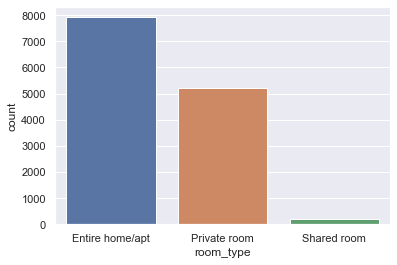

In [27]:
sns.countplot(airbnb["room_type"], label="room_type count")

Los datos no están balanceados, se tendrá que tener en cuenta a la hora de usar los algoritmos de clasificación. <br/>
Al tener tan pocos registros de shared room, va a ser muy dificil que los modelos sean capaces de acertar predicciones para este tipo.

In [28]:
num_airbnb = airbnb.drop(columns=["neighbourhood_group","neighbourhood","room_type"], axis=1, inplace=False)

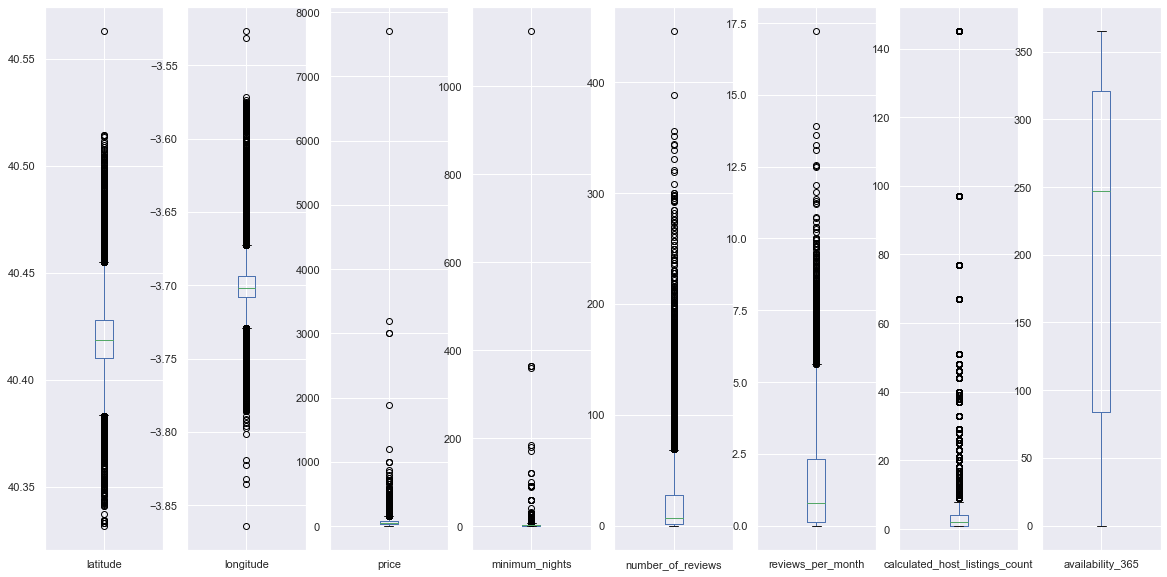

In [29]:
num_airbnb.plot(kind="box", subplots=True, sharex=False, sharey=False,figsize=(20,10))
plt.show()

Analizando el box and whiskers hay muchos outliers. Vamos a analizar la distribución para ver si nos conviene quitarlos.

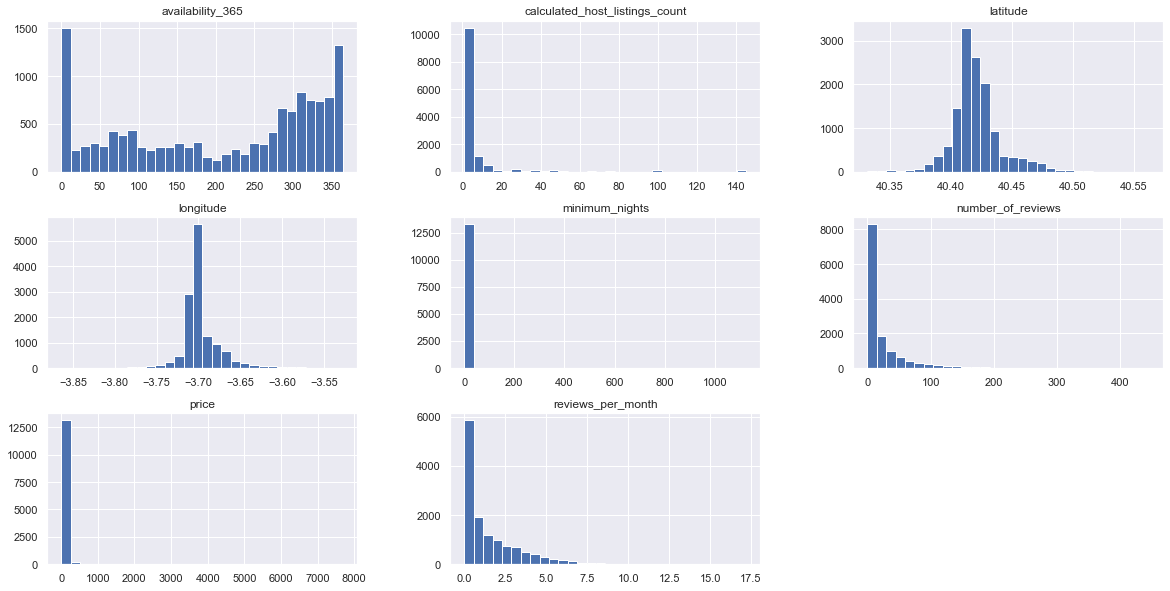

In [30]:
num_airbnb.hist(bins=30,figsize=(20,10))
plt.show()

In [31]:
num_airbnb.describe()

latitude     longitude         price  minimum_nights  \
count  13321.000000  13321.000000  13321.000000    13321.000000   
mean      40.420730     -3.697268     69.171834        3.010885   
std        0.020344      0.023832    103.721126       12.835619   
min       40.331888     -3.863907      9.000000        1.000000   
25%       40.410090     -3.707856     31.000000        1.000000   
50%       40.418731     -3.701602     53.000000        2.000000   
75%       40.427997     -3.693818     80.000000        3.000000   
max       40.562736     -3.526821   7700.000000     1125.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       13321.000000       13321.000000                    13321.000000   
mean           22.986037           1.520329                        7.605885   
std            38.406006           1.852367                       19.619972   
min             0.000000           0.000000                        1.000000   
25%             1.000000           0.110000                        1.000000   
50%             7.000000           0.780000                        2.000000   
75%            28.000000           2.320000                        4.000000   
max           446.000000          17.210000                      145.000000   

       availability_365  
count      13321.000000  
mean         205.867202  
std          126.968961  
min            0.000000  
25%           84.000000  
50%          247.000000  
75%          321.000000  
max          365.000000

availability_365: OK <br/>
calculated_host_listings_count: Vamos a estudiar la ditribución por room_type para analizar si podemos descartar los valores altos.<br/>
latitud: OK <br/>
longitud: OK <br/>
minimum_nights: Vamos a estudiar la distribución por room_type para analizar si podemos descartar los valores altos. <br/>
number_of_reviews: Vamos a estudiar la distribución por room_type para analizar si podemos descartar los valores altos.<br/>
price: Vamos a estudiar la distribución por room_type para analizar si podemos descartar los valores altos.<br/>
reviews_per_month: Vamos a estudiar la distribución por room_type para analizar si podemos descartar los valores altos.<br/>

In [32]:
def hist_by_room_type(data, focus):
    data[data["room_type"] == "Entire home/apt"][focus].hist(bins=30, figsize=(30,10))
    data[data["room_type"] == "Private room"][focus].hist(bins=30, figsize=(30,10))
    data[data["room_type"] == "Shared room"][focus].hist(bins=30, figsize=(30,10))
    plt.title(focus)
    plt.show()

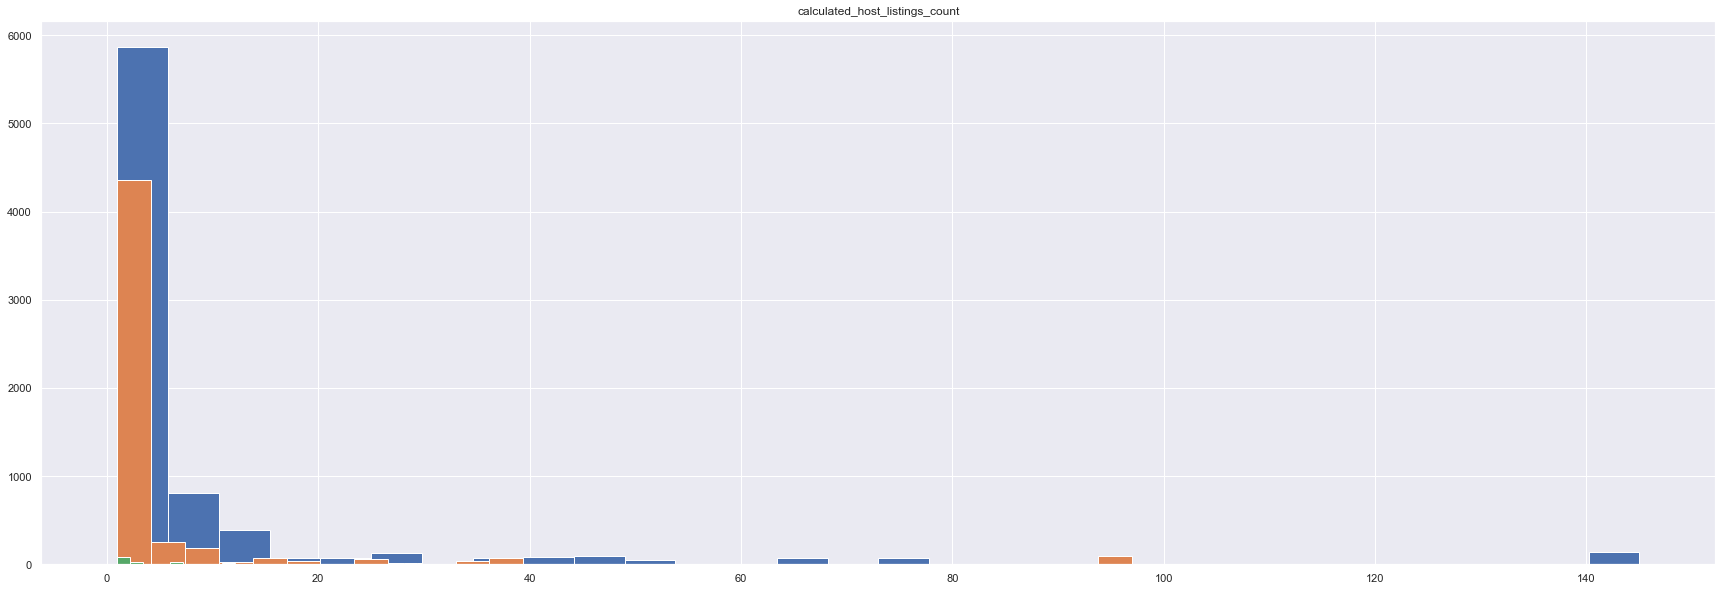

In [33]:
hist_by_room_type(airbnb,"calculated_host_listings_count")

Vamos a descartar los valores > 60 puesto que son pocos y los podemos considerar como outliers. Al descartar estos valores ayudamos, indirectamente, a balancear "shared room".

In [34]:
airbnb_cleaned = airbnb[airbnb["calculated_host_listings_count"] < 60]

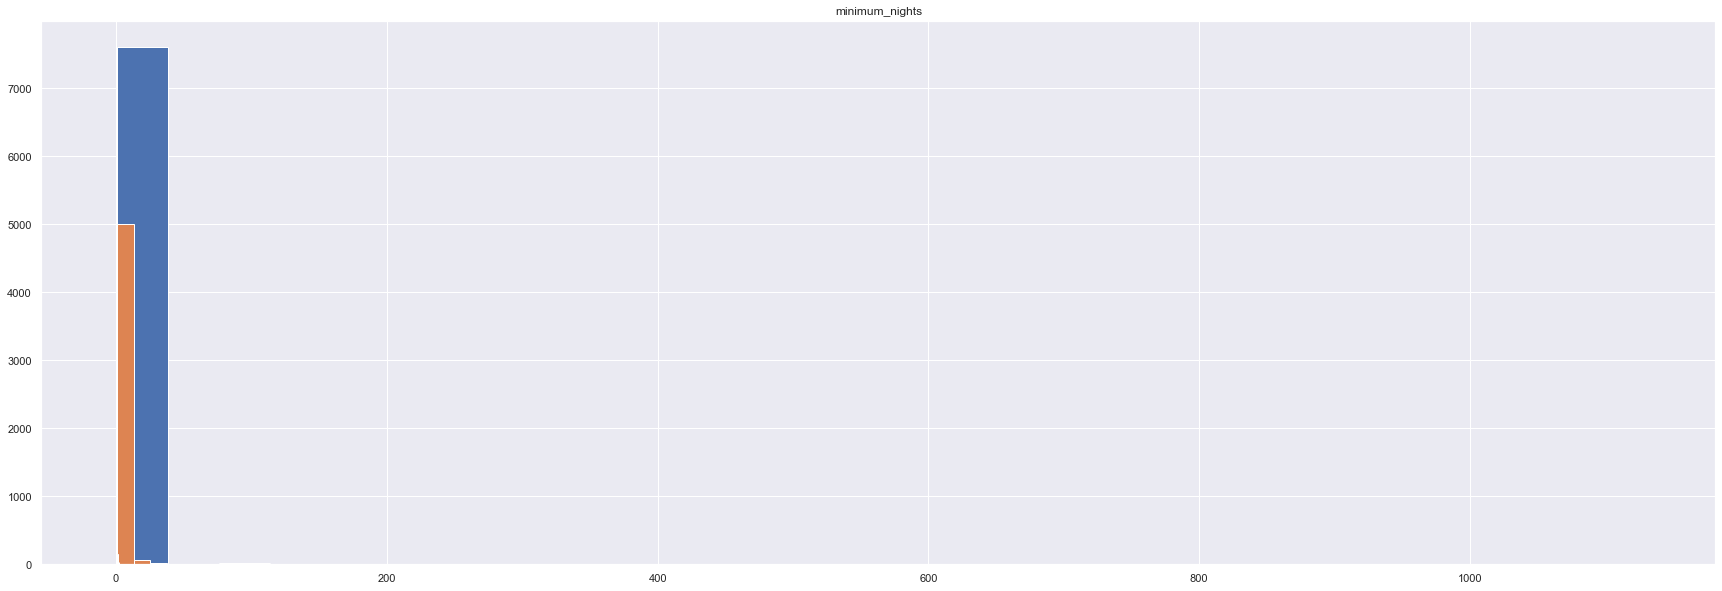

In [35]:
hist_by_room_type(airbnb_cleaned,"minimum_nights")

Vamos a descartar los valores > 60 puesto que son pocos y los podemos considerar como outliers. Al descartar estos valores ayudamos, indirectamente, a balancear "shared room".

In [36]:
airbnb_cleaned = airbnb_cleaned[airbnb_cleaned["minimum_nights"] < 20]

Vamos a descartar los valores > 20 puesto que son pocos y los podemos considerar como outliers. Al descartar estos valores ayudamos, indirectamente, a balancear "shared room". Otra alternativa es categorizar la variable, pero supondría pérdida de información.

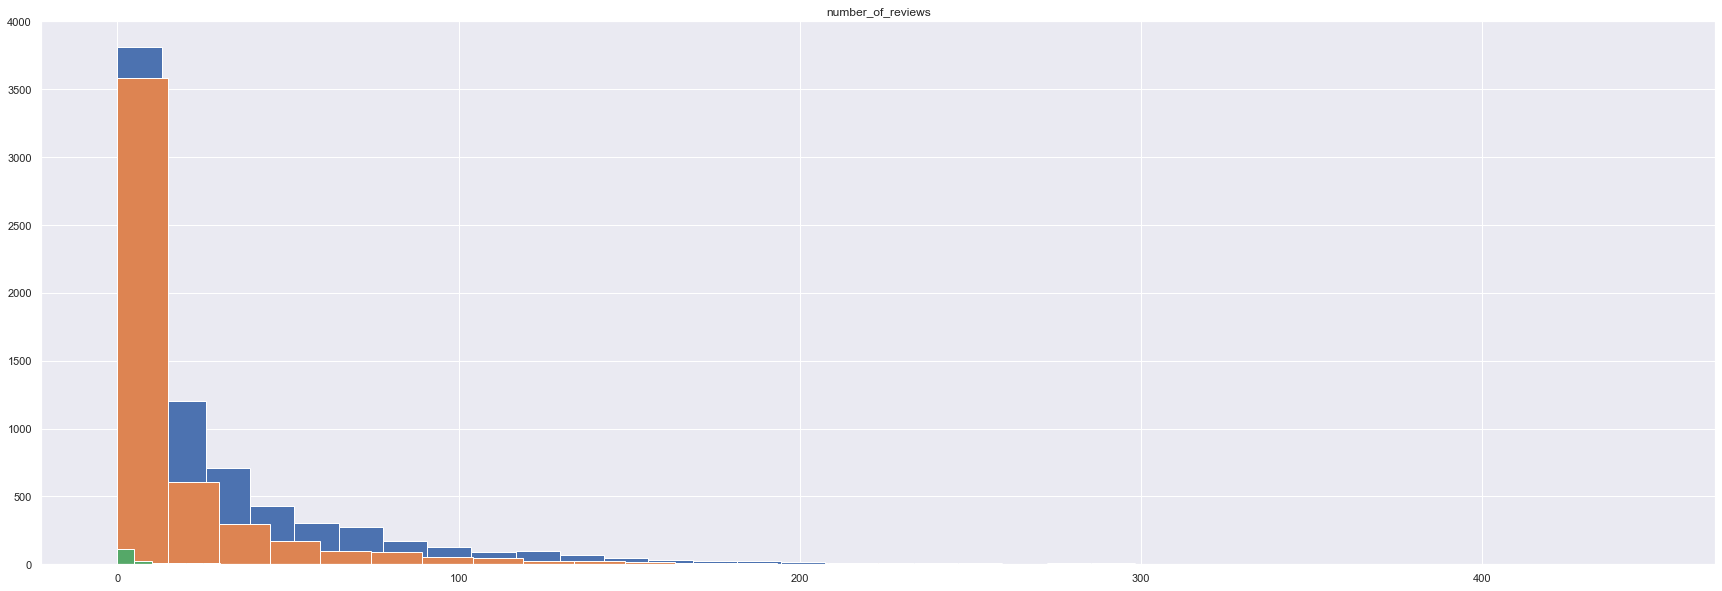

In [37]:
hist_by_room_type(airbnb_cleaned,"number_of_reviews")

Vamos a descartar los valores > 200 puesto que son pocos y los podemos considerar como outliers. Al descartar estos valores ayudamos, indirectamente, a balancear "shared room". Aquí también podríamos categorizar los valores.

In [38]:
airbnb_cleaned = airbnb_cleaned[airbnb_cleaned["number_of_reviews"] < 200]

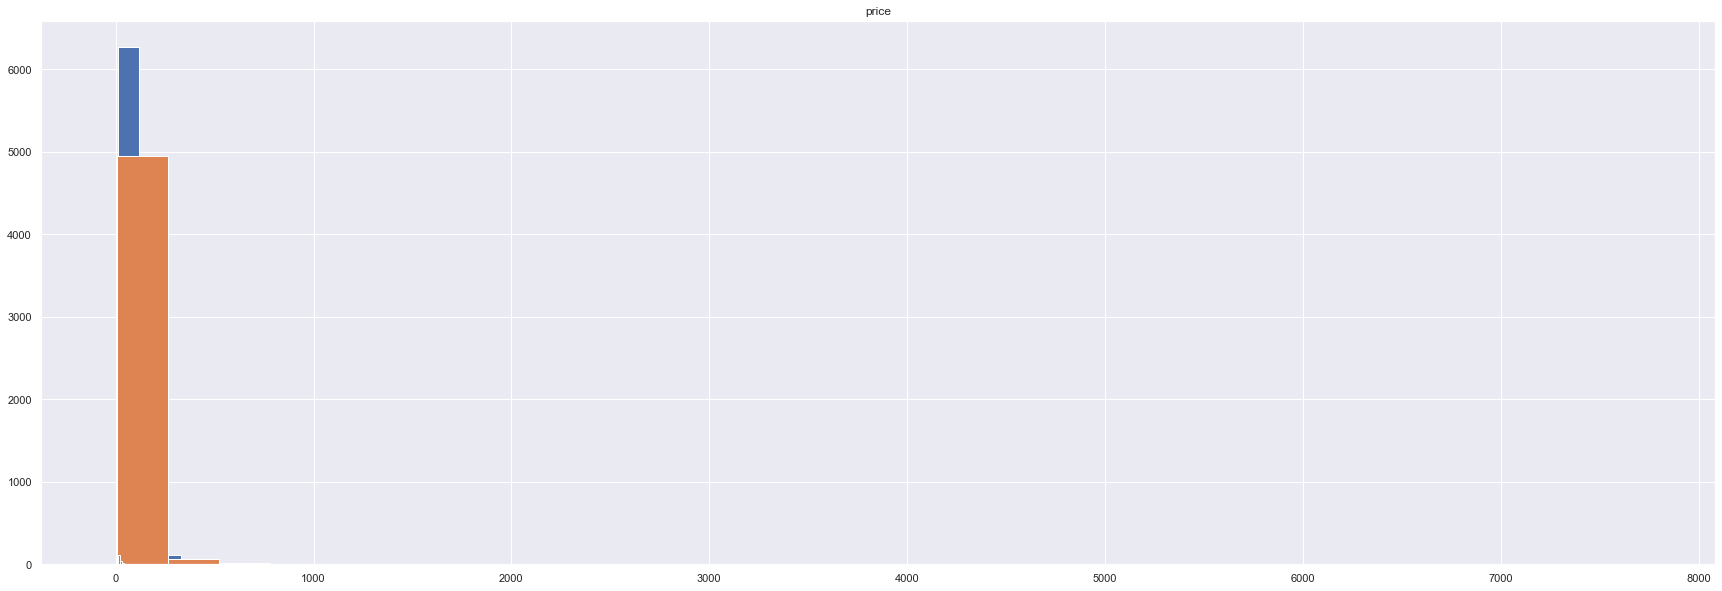

In [39]:
hist_by_room_type(airbnb_cleaned,"price")

Vamos a descartar los valores > 450 puesto que son pocos y los podemos considerar como outliers. Al descartar estos valores ayudamos, indirectamente, a balancear "shared room".

In [40]:
airbnb_cleaned = airbnb_cleaned[airbnb_cleaned["price"] < 450]

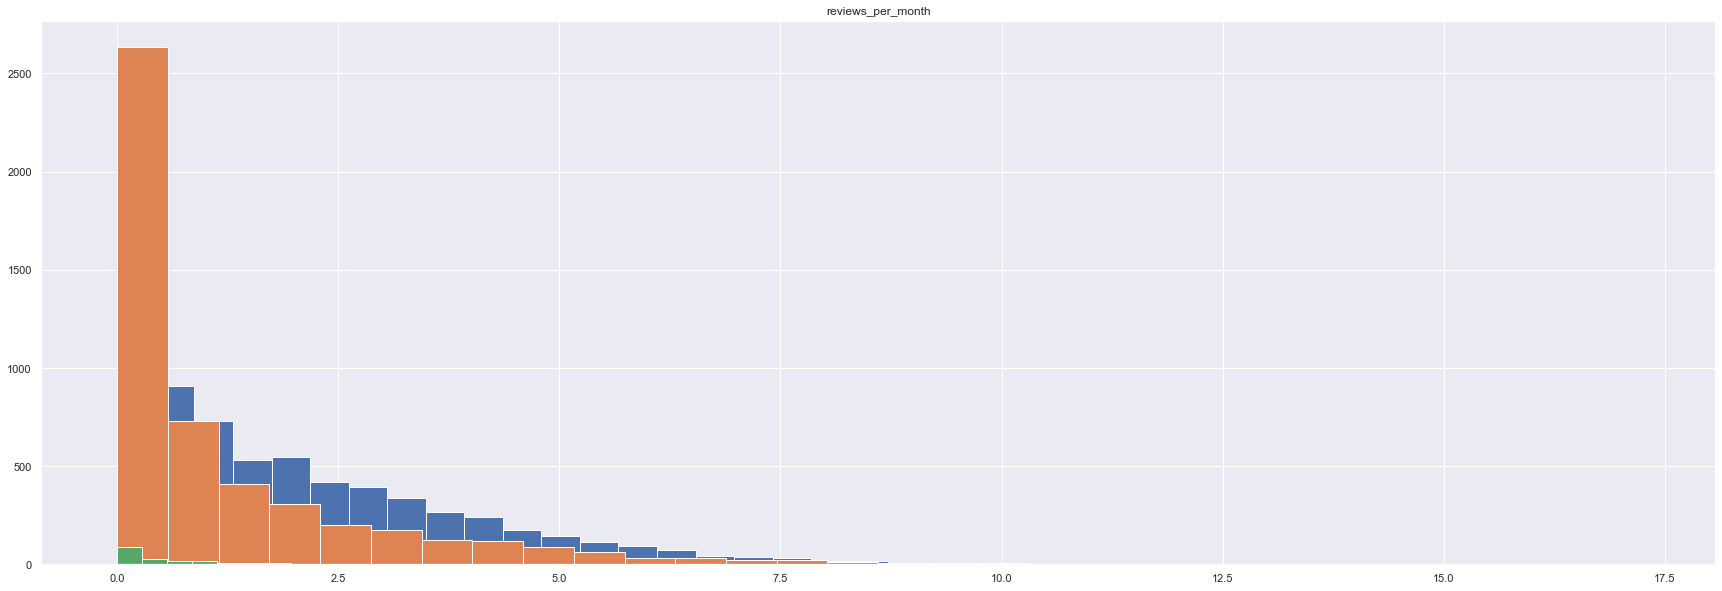

In [41]:
hist_by_room_type(airbnb_cleaned,"reviews_per_month")

Vamos a descartar los valores > 10 puesto que son pocos y los podemos considerar como outliers. Al descartar estos valores ayudamos, indirectamente, a balancear "shared room". También sería un candidato a ser categorizada

In [42]:
airbnb_cleaned = airbnb_cleaned[airbnb_cleaned["reviews_per_month"] < 10]

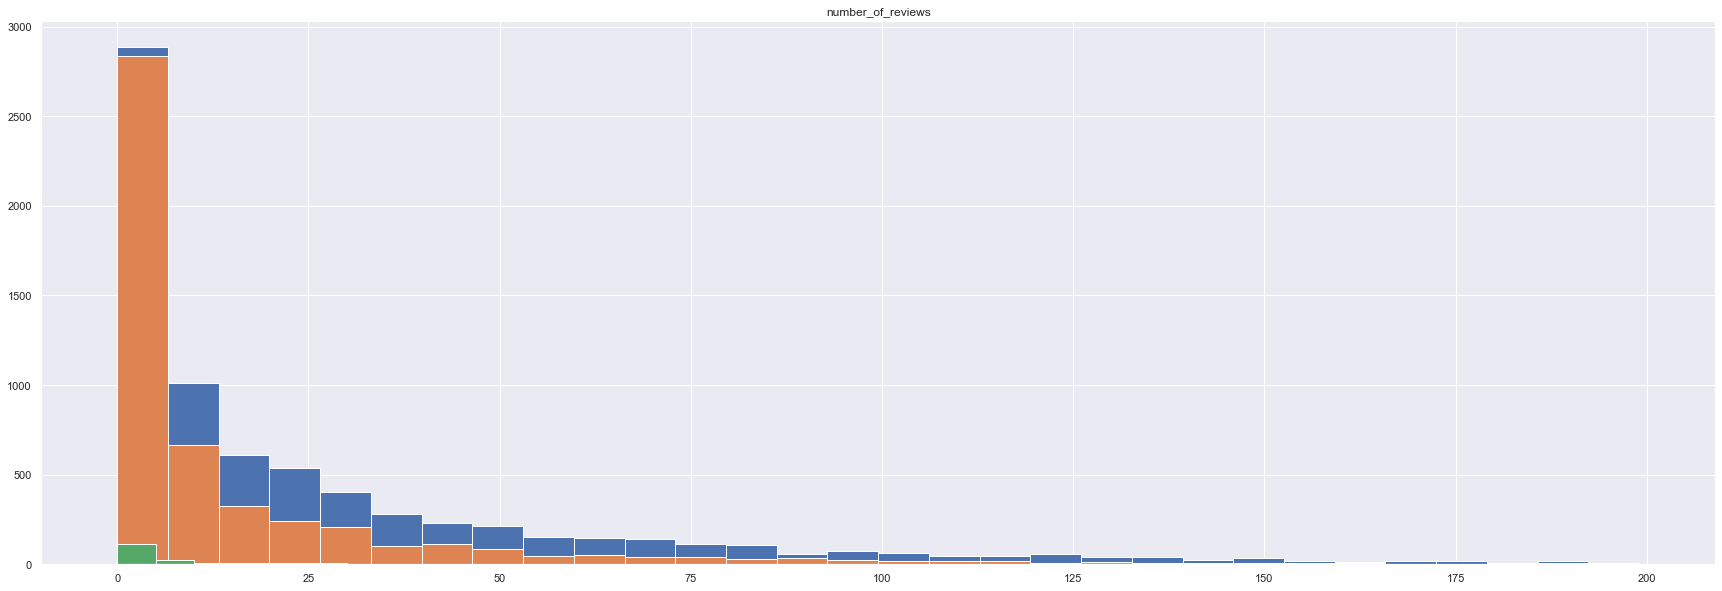

In [43]:
hist_by_room_type(airbnb_cleaned,"number_of_reviews")

Vamos a descartar los valores > 160 puesto que son pocos y los podemos considerar como outliers. Al descartar estos valores ayudamos, indirectamente a balancear "shared room". De nuevo sería candidato a categorizar la variable.

In [44]:
airbnb_cleaned = airbnb_cleaned[airbnb_cleaned["number_of_reviews"] < 160]

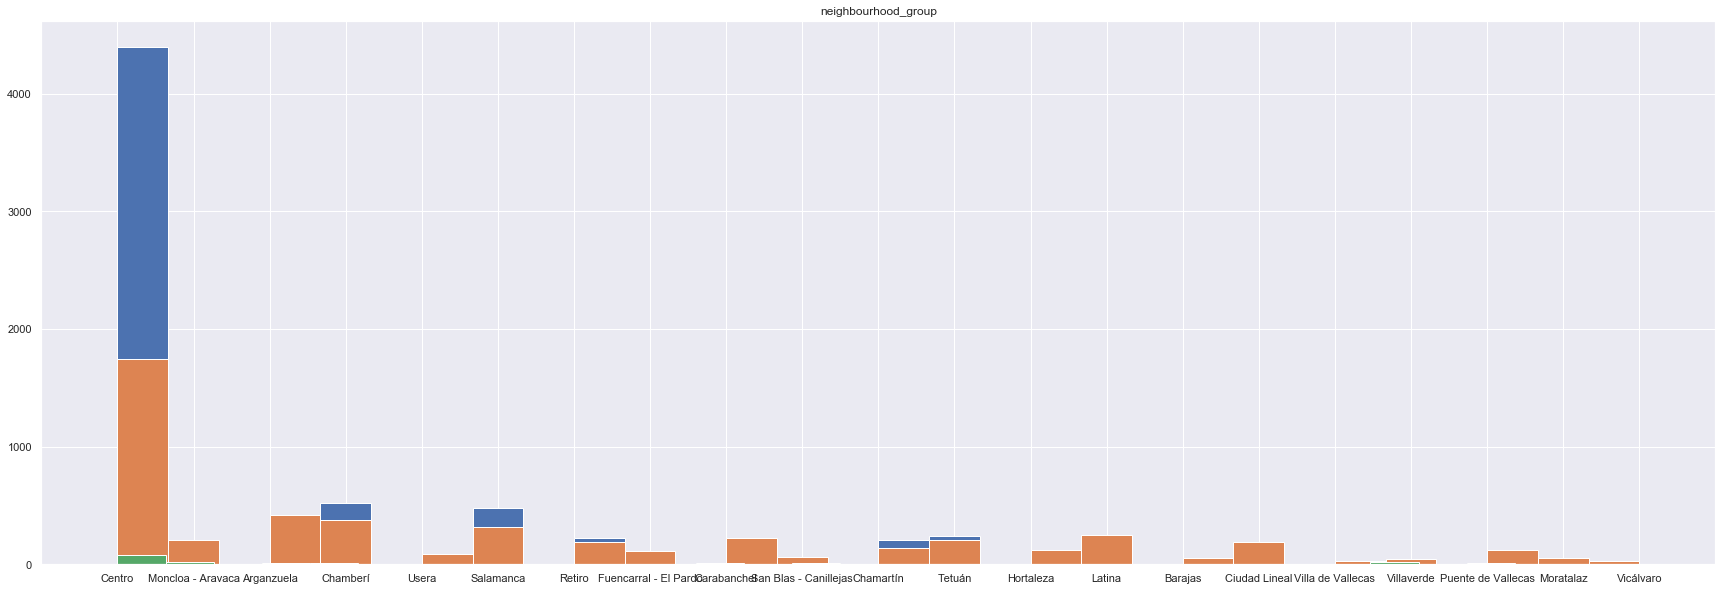

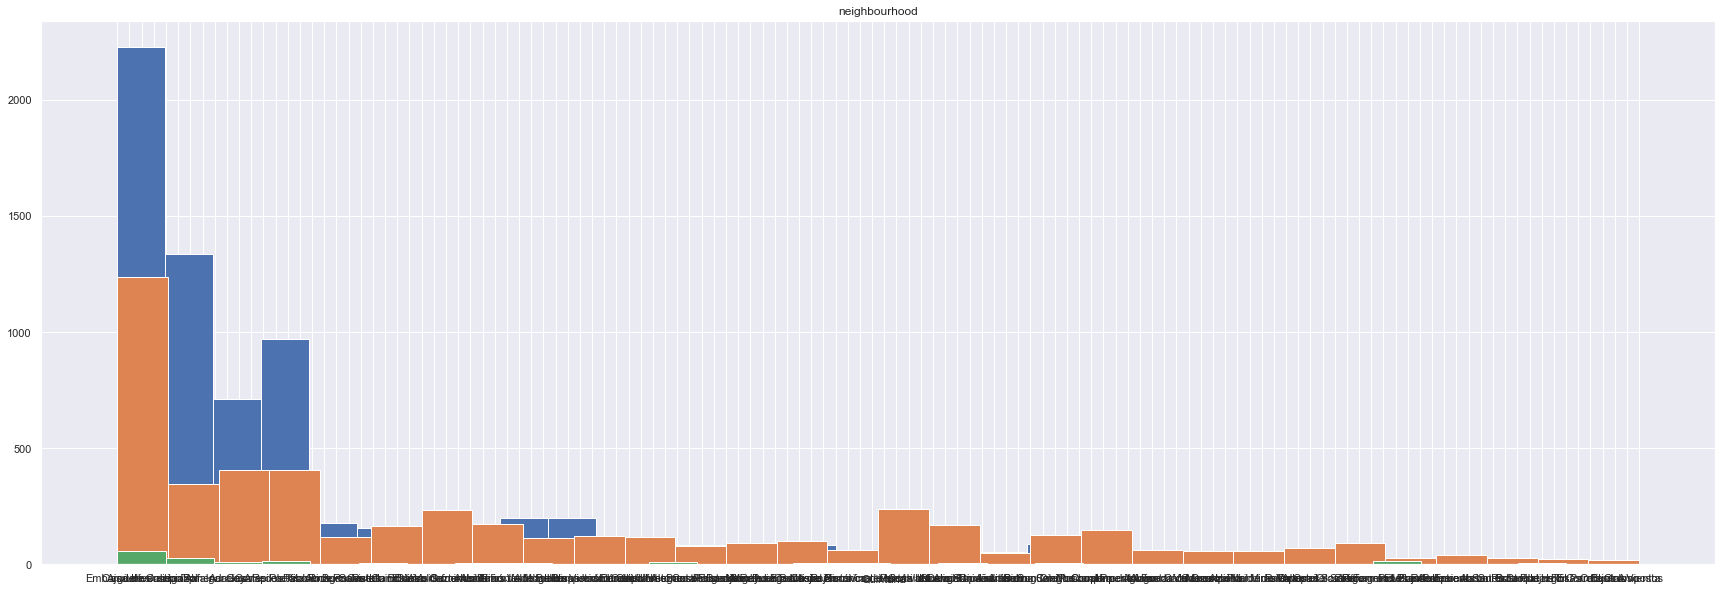

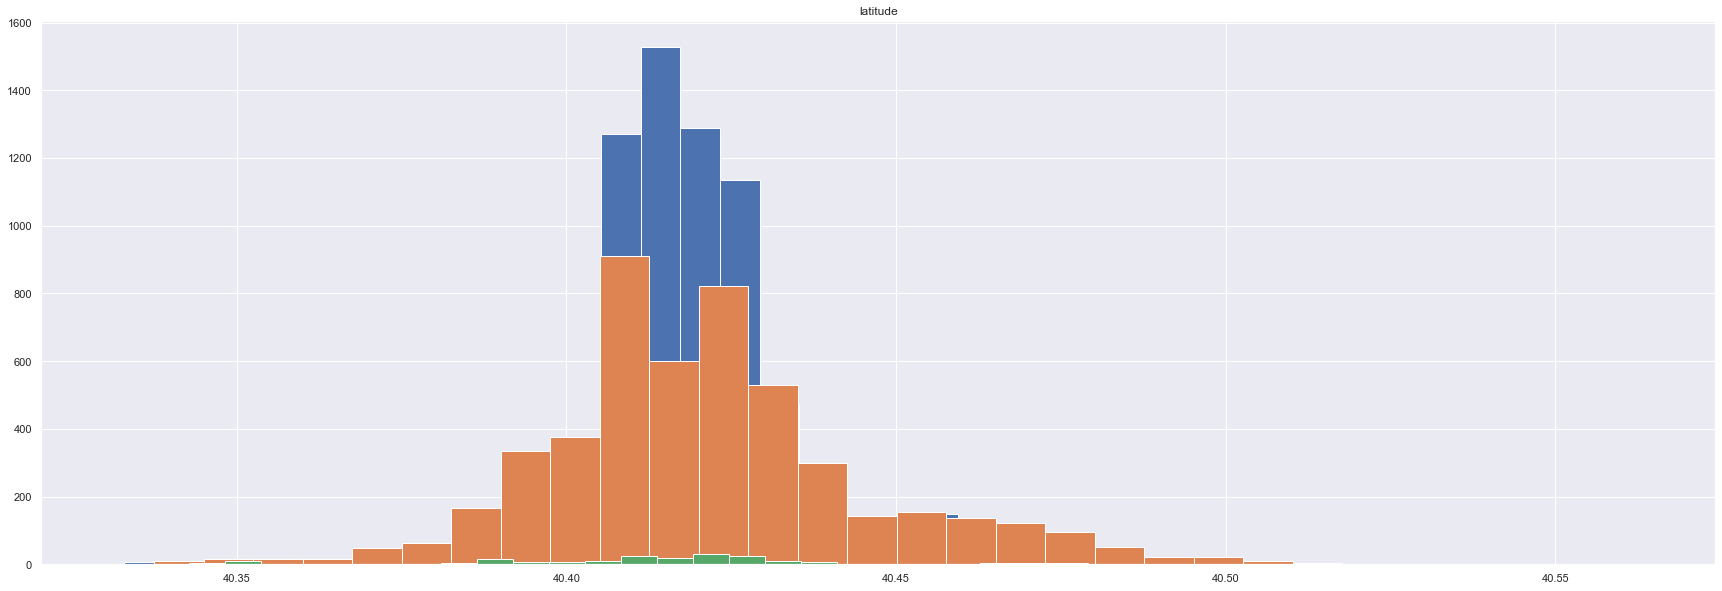

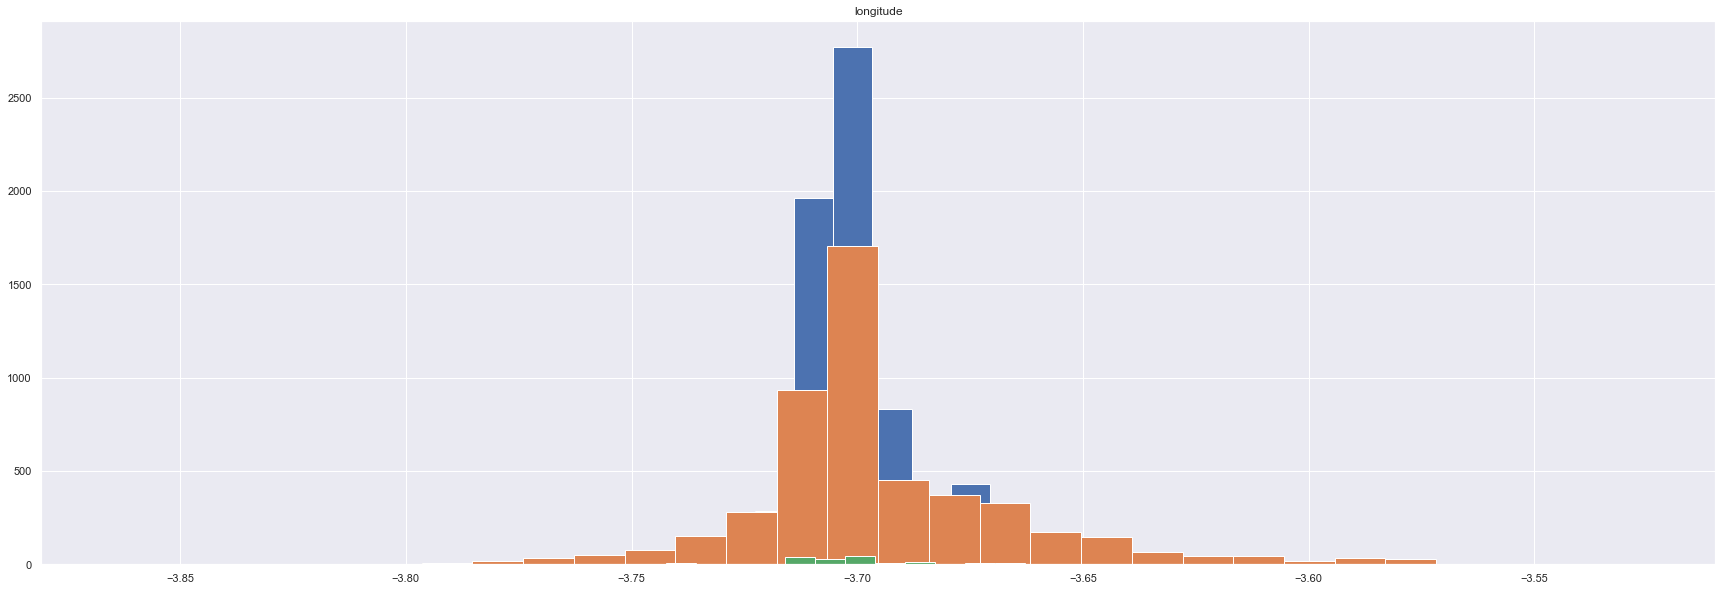

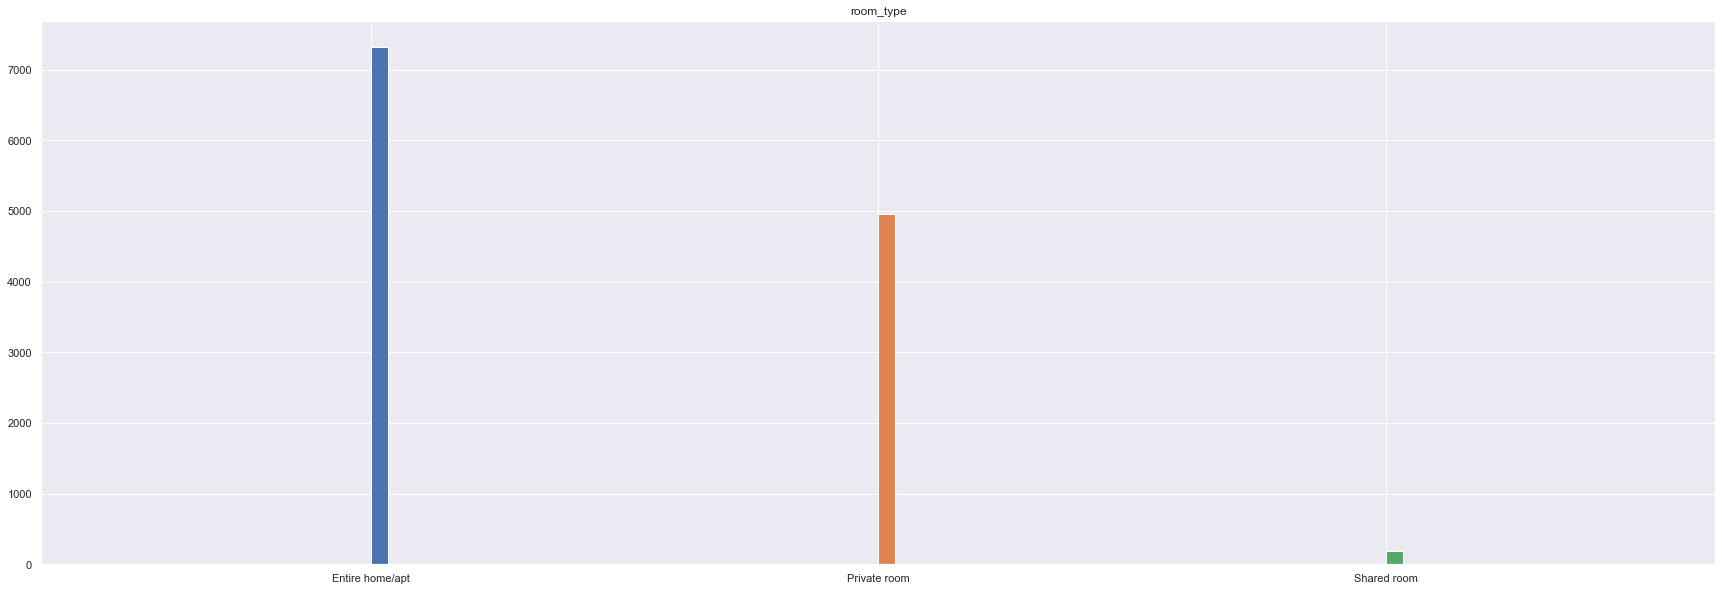

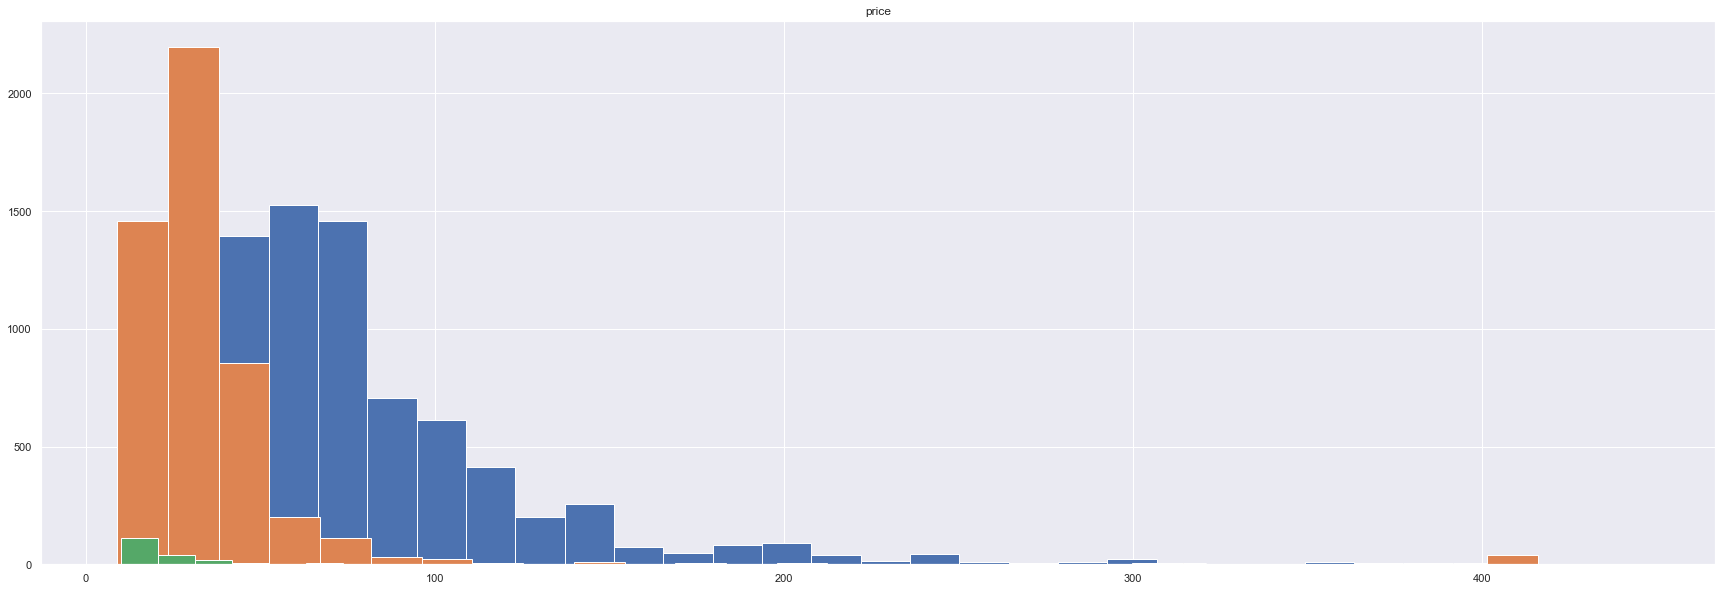

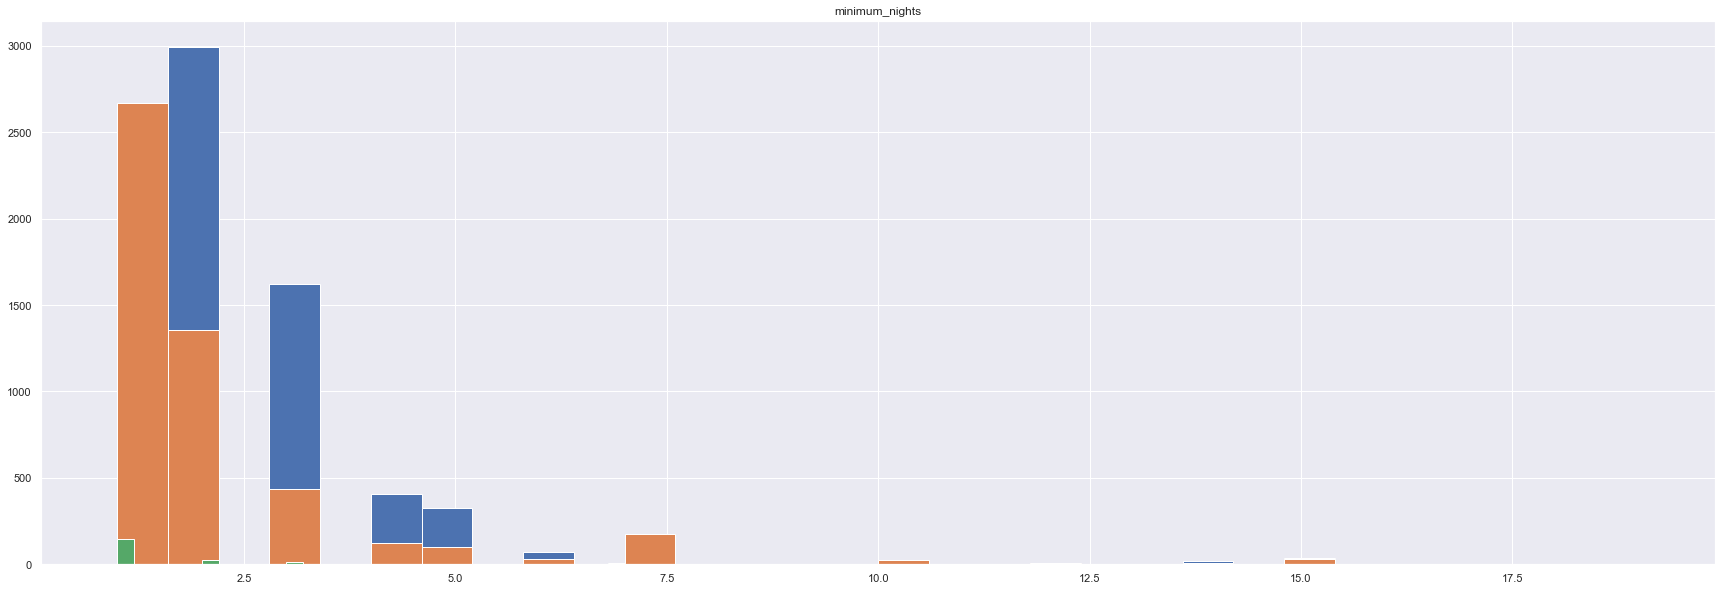

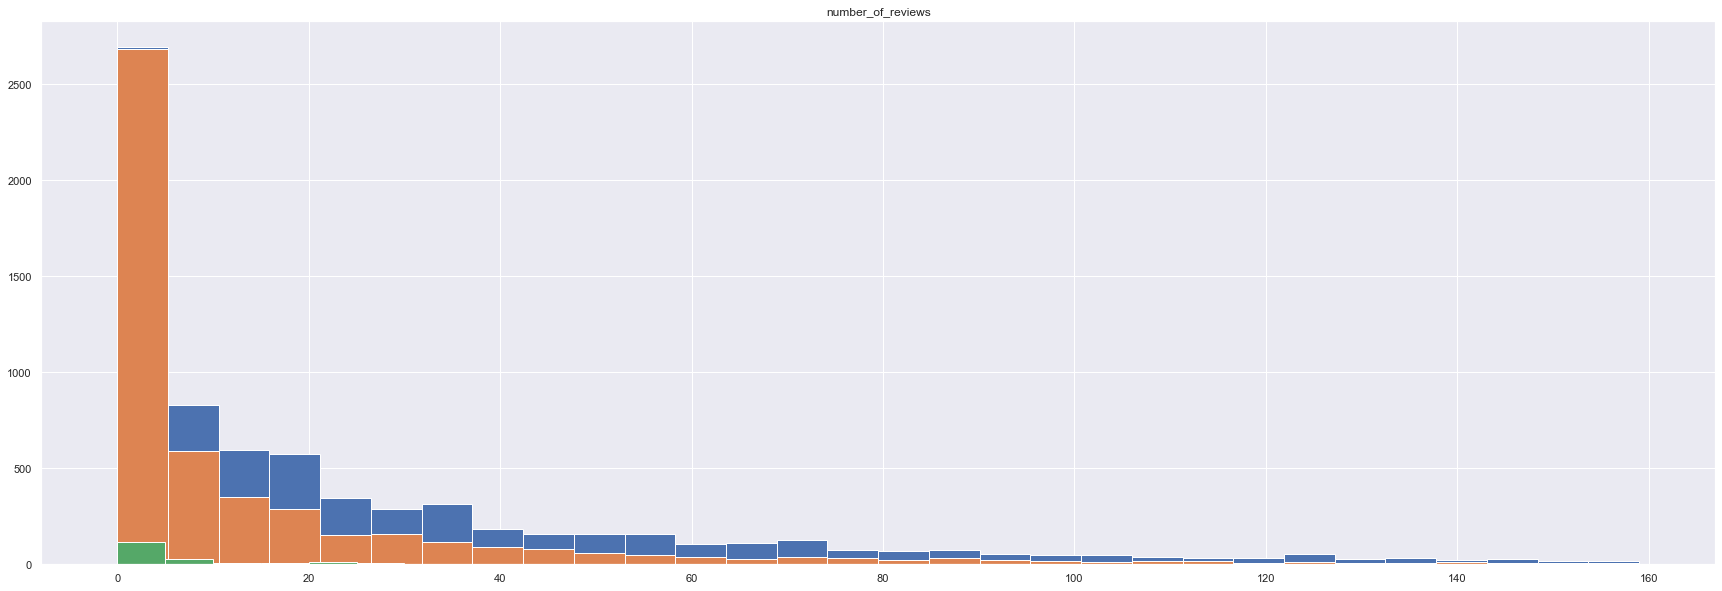

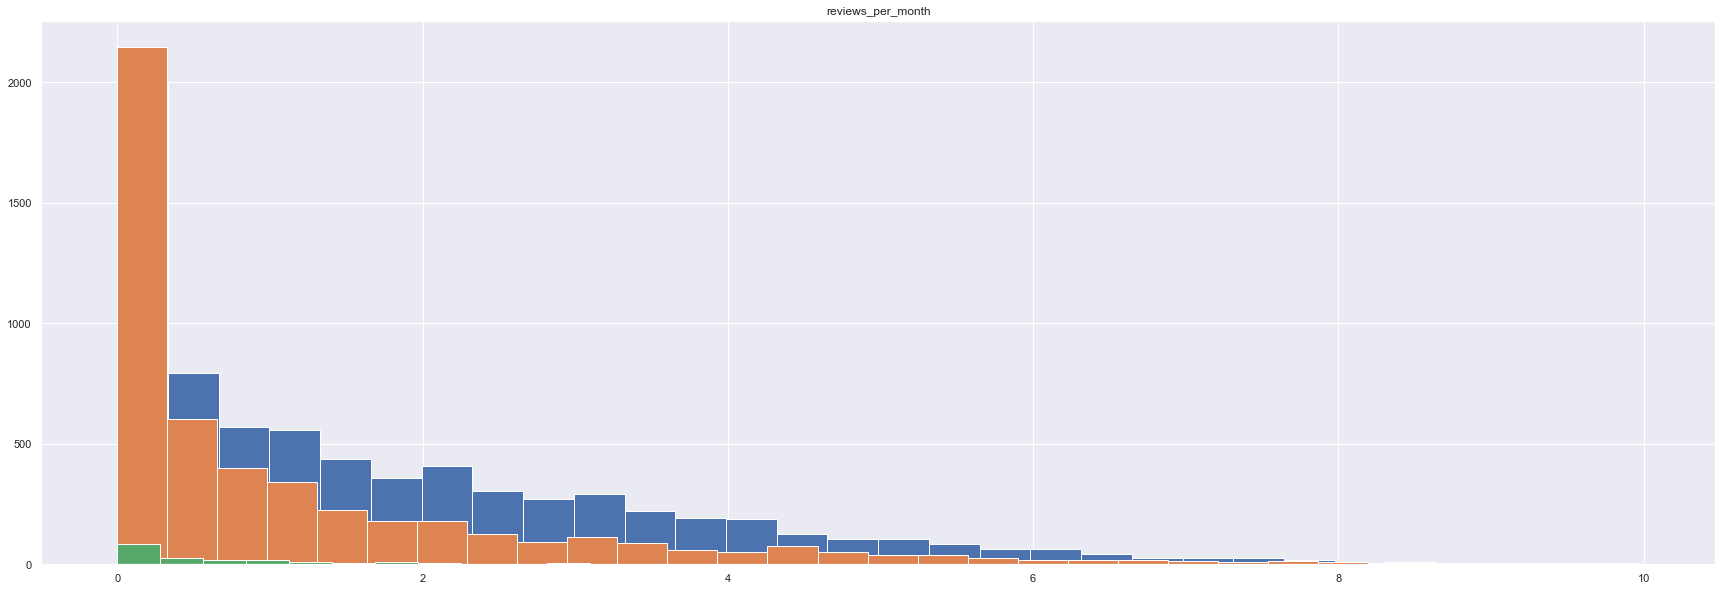

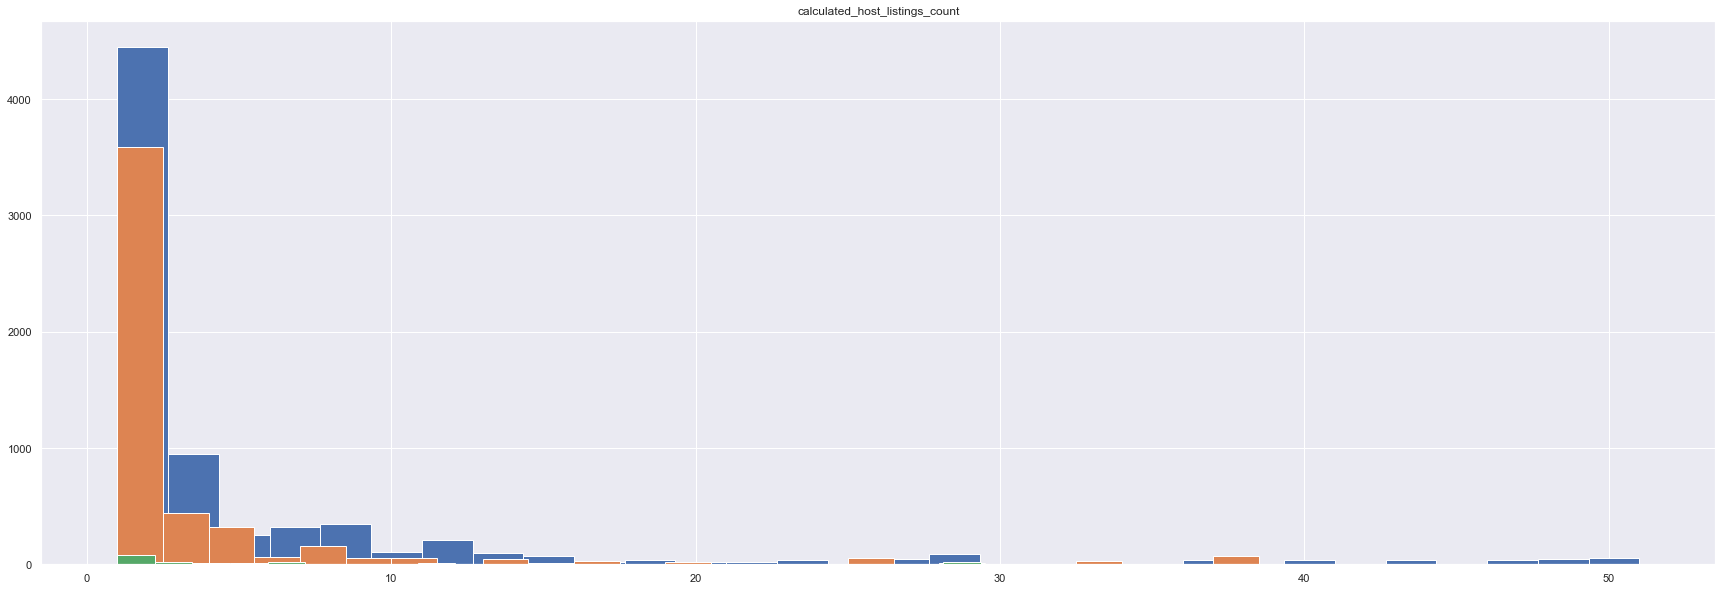

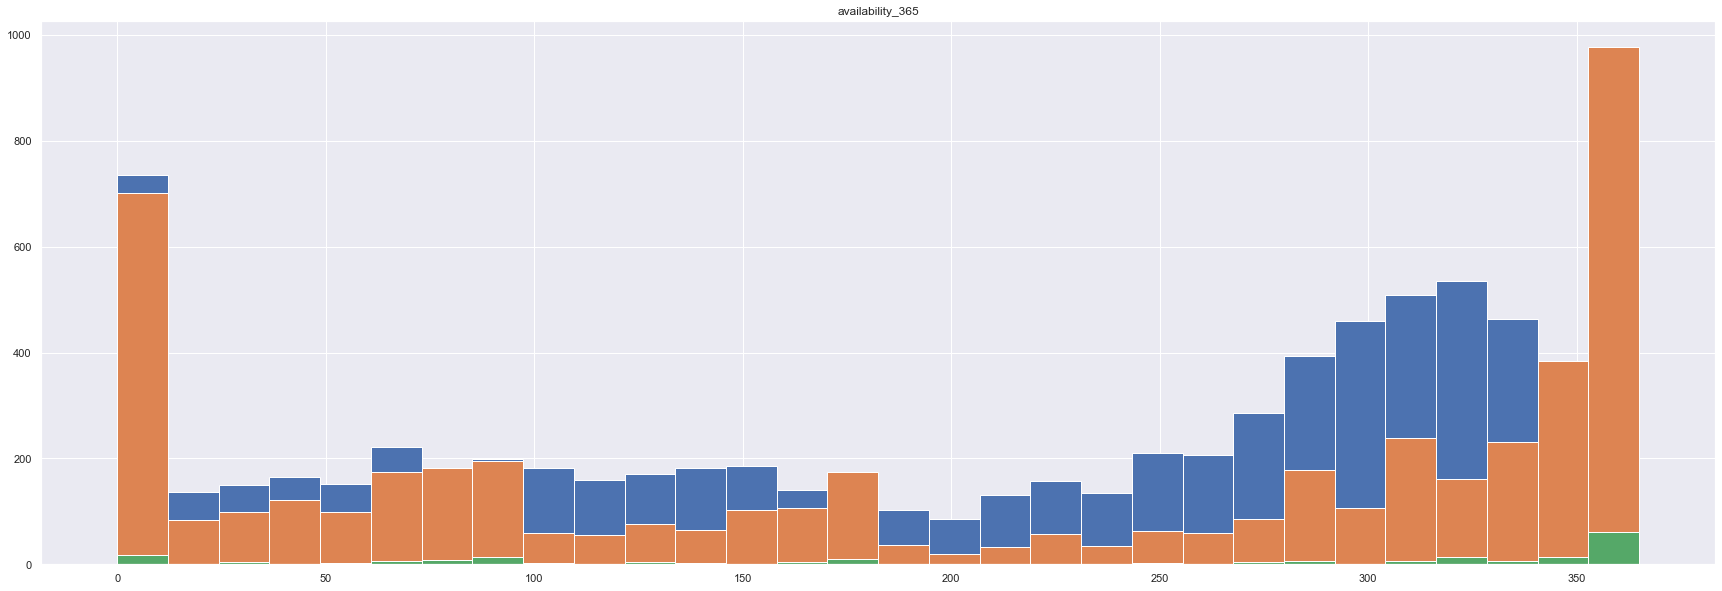

In [45]:
for col in airbnb_cleaned.columns :
    hist_by_room_type(airbnb_cleaned, col)

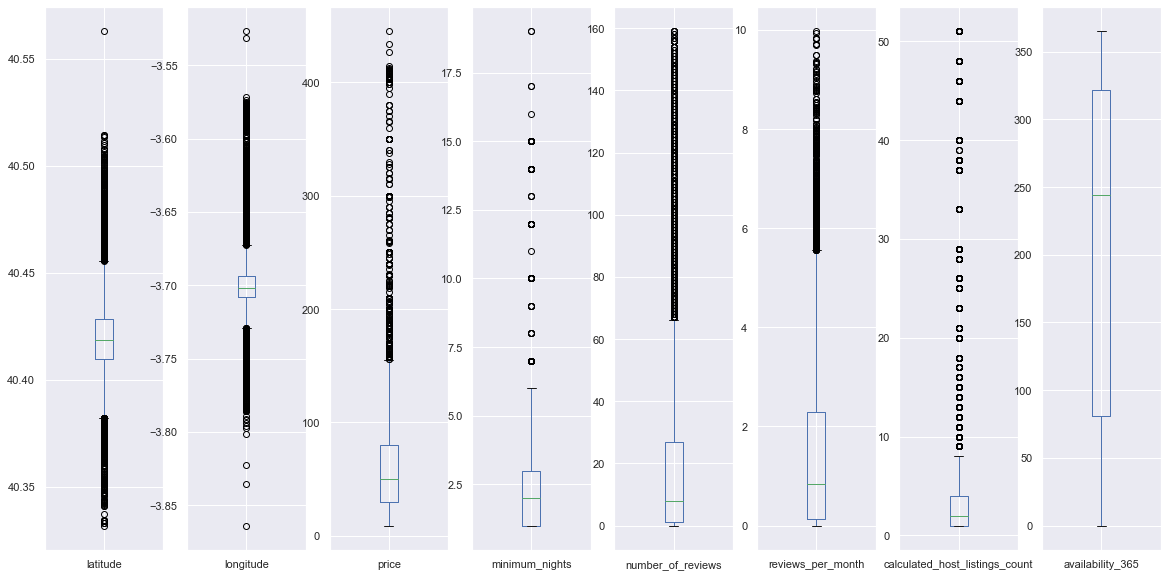

In [46]:
airbnb_cleaned.plot(kind="box", subplots=True, sharex=False, sharey=False,figsize=(20,10))
plt.show()

In [47]:
airbnb_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12479 entries, 1 to 13320
Data columns (total 11 columns):
neighbourhood_group               12479 non-null object
neighbourhood                     12479 non-null object
latitude                          12479 non-null float64
longitude                         12479 non-null float64
room_type                         12479 non-null object
price                             12479 non-null int64
minimum_nights                    12479 non-null int64
number_of_reviews                 12479 non-null int64
reviews_per_month                 12479 non-null float64
calculated_host_listings_count    12479 non-null int64
availability_365                  12479 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


In [48]:
airbnb_cleaned.describe()

latitude     longitude         price  minimum_nights  \
count  12479.000000  12479.000000  12479.000000    12479.000000   
mean      40.420709     -3.697197     63.786041        2.315971   
std        0.020638      0.024064     49.459593        1.864051   
min       40.331888     -3.863907      9.000000        1.000000   
25%       40.409829     -3.707945     30.000000        1.000000   
50%       40.418726     -3.701554     50.000000        2.000000   
75%       40.428173     -3.693658     80.000000        3.000000   
max       40.562736     -3.526821    445.000000       19.000000   

       number_of_reviews  reviews_per_month  calculated_host_listings_count  \
count       12479.000000       12479.000000                    12479.000000   
mean           20.719288           1.499031                        4.572642   
std            30.047691           1.754177                        8.144334   
min             0.000000           0.000000                        1.000000   
25%             1.000000           0.130000                        1.000000   
50%             8.000000           0.840000                        2.000000   
75%            27.000000           2.300000                        4.000000   
max           159.000000           9.970000                       51.000000   

       availability_365  
count      12479.000000  
mean         204.372626  
std          128.001418  
min            0.000000  
25%           81.000000  
50%          244.000000  
75%          322.000000  
max          365.000000

Tras descartar los outliers pasamos a tener 12479 registros. Podíamos haber purgado algún registro mas pero, al tener tan pocos datos, corremos el riesgo de perder represemntantes de casos poco habituales. 
Si esto ocurre el modelo no podrá predecir estos casos porque no los ha visto en el entrenamiento.


### Test Set / Train Set

En primer lugar vamos a separar el training set y el test set para no hacer presuposiciones sobre los datos y acabar overfiting el modelo.<br/>
Vamos a usar StratifiedShuffleSplit para generar los 2 sets estratificando por la columna neighbourhood_group. Creo que tiene sentido que el test y training set tengan registros de todos los barrios. He decidido usar esta columna en vez de neighbourhood porque  la segunda es demasiado detallada y, en algunos casos, hay pocos registros por neighbourhood. Además


In [49]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Nota, he probado con neighbourhood, pero al tener categorias con menos de 2 valores, no podemos usar esta columna para stratificar. 
# Esto nos deja 2 opciones: 
# 1- Borrar los registros cuya categoría sólo tiene 1 registro. Pero perdemos registros valiosos.
# 2- Usar neighbourhood_group, que agrupa los neighbourhood y no tiene el mismo inconveniente.
for train_indices, test_indices in split.split(airbnb_cleaned, airbnb_cleaned["neighbourhood_group"]):
    strat_train_set = airbnb_cleaned.loc[airbnb_cleaned.index.intersection(train_indices)]
    strat_test_set = airbnb_cleaned.loc[airbnb_cleaned.index.intersection(test_indices)]

In [50]:
cleaned_test_path = os.path.join("sets","strat_test_set_cleaned.csv")
cleaned_train_path = os.path.join("sets","strat_train_set_cleaned.csv")

In [51]:
strat_test_set.to_csv(cleaned_test_path, index=False)
strat_train_set.to_csv(cleaned_train_path, index=False)

In [52]:
# Comprobamos si hay algún valor NaN o NULL.
strat_test_set[strat_test_set.isna().any(axis=1)]

Empty DataFrame
Columns: [neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365]
Index: []

Lo volvemos a cargar desde disco.

In [53]:
test_set = pd.read_csv(cleaned_test_path)
train_set = pd.read_csv(cleaned_train_path)

Comprobamos que no haya ningún NaN.

In [54]:
train_set[train_set.isna().any(axis=1)]

Empty DataFrame
Columns: [neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365]
Index: []

In [55]:
train_set[train_set.isna().any(axis=1)]

Empty DataFrame
Columns: [neighbourhood_group, neighbourhood, latitude, longitude, room_type, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, availability_365]
Index: []

In [56]:
x_train = train_set.drop(columns=["room_type"], axis=1, inplace=False)
y_train = train_set[["room_type"]]
x_num_train = x_train.drop(columns=["neighbourhood_group","neighbourhood"], axis=1, inplace=False)
x_cat_train = x_train[["neighbourhood_group","neighbourhood"]]

In [57]:
x_cat_train

neighbourhood_group                 neighbourhood
0                    Centro                   Embajadores
1         Moncloa - Aravaca                     Argüelles
2                    Latina                      Cármenes
3                    Centro                      Justicia
4     Fuencarral - El Pardo                    Peñagrande
...                     ...                           ...
9341              Chamartín                  Nueva España
9342      Moncloa - Aravaca                     Argüelles
9343     Puente de Vallecas                     San Diego
9344              Vicálvaro  Casco Histórico de Vicálvaro
9345  San Blas - Canillejas                         Rejas

[9346 rows x 2 columns]

### Analizamos el training set

Vamos a ver cómo de separados están los room_type por cada columna:

In [58]:
from sklearn.preprocessing import OrdinalEncoder

#Convertimos room_type a numérico para poder pintarlo con matplotlib.
ordinal_encoder = OrdinalEncoder()
ord_train = ordinal_encoder.fit_transform(train_set[["room_type","neighbourhood_group","neighbourhood"]])
ord_train = pd.DataFrame(ord_train, columns=["room_type","neighbourhood_group","neighbourhood"])
ord_train = pd.concat([ord_train,x_num_train], axis=1)
ord_train

room_type  neighbourhood_group  neighbourhood   latitude  longitude  \
0           0.0                  3.0           49.0  40.413418  -3.706838   
1           0.0                 10.0           16.0  40.424920  -3.713446   
2           1.0                  9.0           43.0  40.403410  -3.740842   
3           0.0                  3.0           63.0  40.420153  -3.696498   
4           1.0                  7.0           86.0  40.482185  -3.725684   
...         ...                  ...            ...        ...        ...   
9341        0.0                  4.0           75.0  40.459619  -3.678258   
9342        0.0                 10.0           16.0  40.425964  -3.713259   
9343        0.0                 12.0          104.0  40.394528  -3.668613   
9344        1.0                 18.0           28.0  40.392659  -3.601758   
9345        1.0                 15.0           98.0  40.443480  -3.585477   

      price  minimum_nights  number_of_reviews  reviews_per_month  \
0        80               5                 18               0.30   
1        40               2                 21               0.25   
2        16               2                 23               0.76   
3       100               4                 31               0.43   
4        21               2                  6               0.69   
...     ...             ...                ...                ...   
9341     45               1                  3               3.00   
9342     75               2                  0               0.00   
9343     60               3                  0               0.00   
9344     20               1                  1               1.00   
9345     23               1                  2               2.00   

      calculated_host_listings_count  availability_365  
0                                  1               188  
1                                  9               195  
2                                  2               250  
3                                  1               232  
4                                  2               249  
...                              ...               ...  
9341                               1                39  
9342                               2               350  
9343                               1                 4  
9344                               1               179  
9345                               1               325  

[9346 rows x 11 columns]

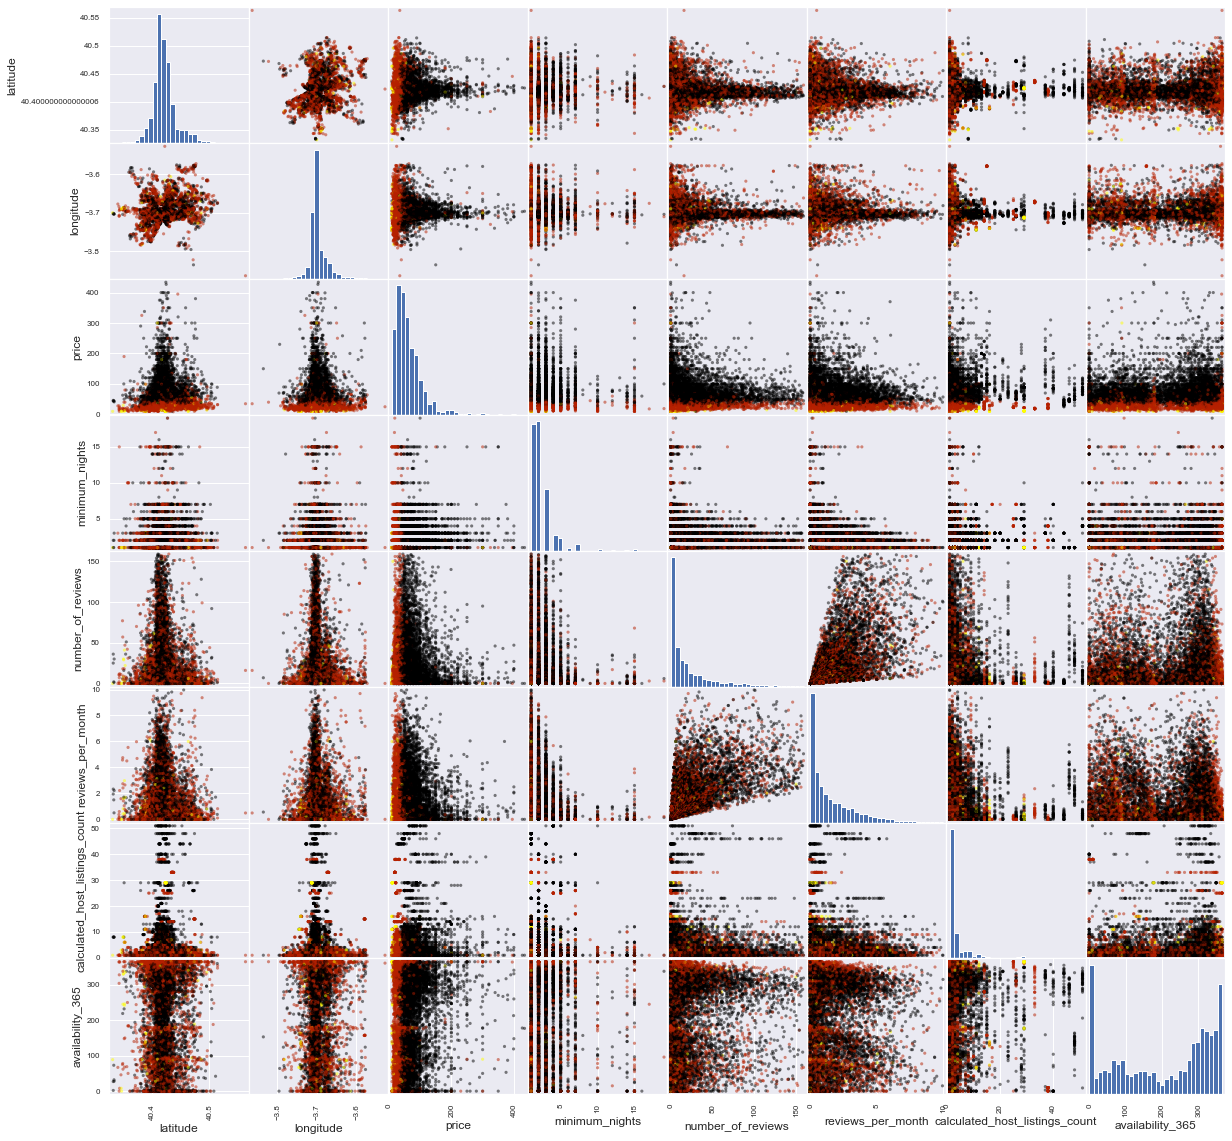

In [59]:
from matplotlib import cm

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(train_set, c = ord_train['room_type'], marker = 'o', s=10, hist_kwds={'bins':30}, figsize=(20,20), cmap = cmap)

En algunas de las columnas se perciben zonas donde predominan un tipo de room_type sobre otros.

Unas variables que parecen insteresantes son neighbourhood_group y neighbourhood_group. Vamos a intentar mostrar cada variable contra estas 2 y tratar de encontrar alguna relación. Para ello tendremos que codificar las variables a valores numéricos.

In [60]:
def scatter_plot(data, x_cols, y_cols, label):
    for x_col in x_cols:
        for y_col in y_cols:
            data.plot(kind="scatter", x=x_col, y=y_col, alpha=0.2, figsize=(20,20),
                      c=label, cmap=plt.get_cmap("jet"), colorbar=True, label=x_col
                     )
    plt.show()

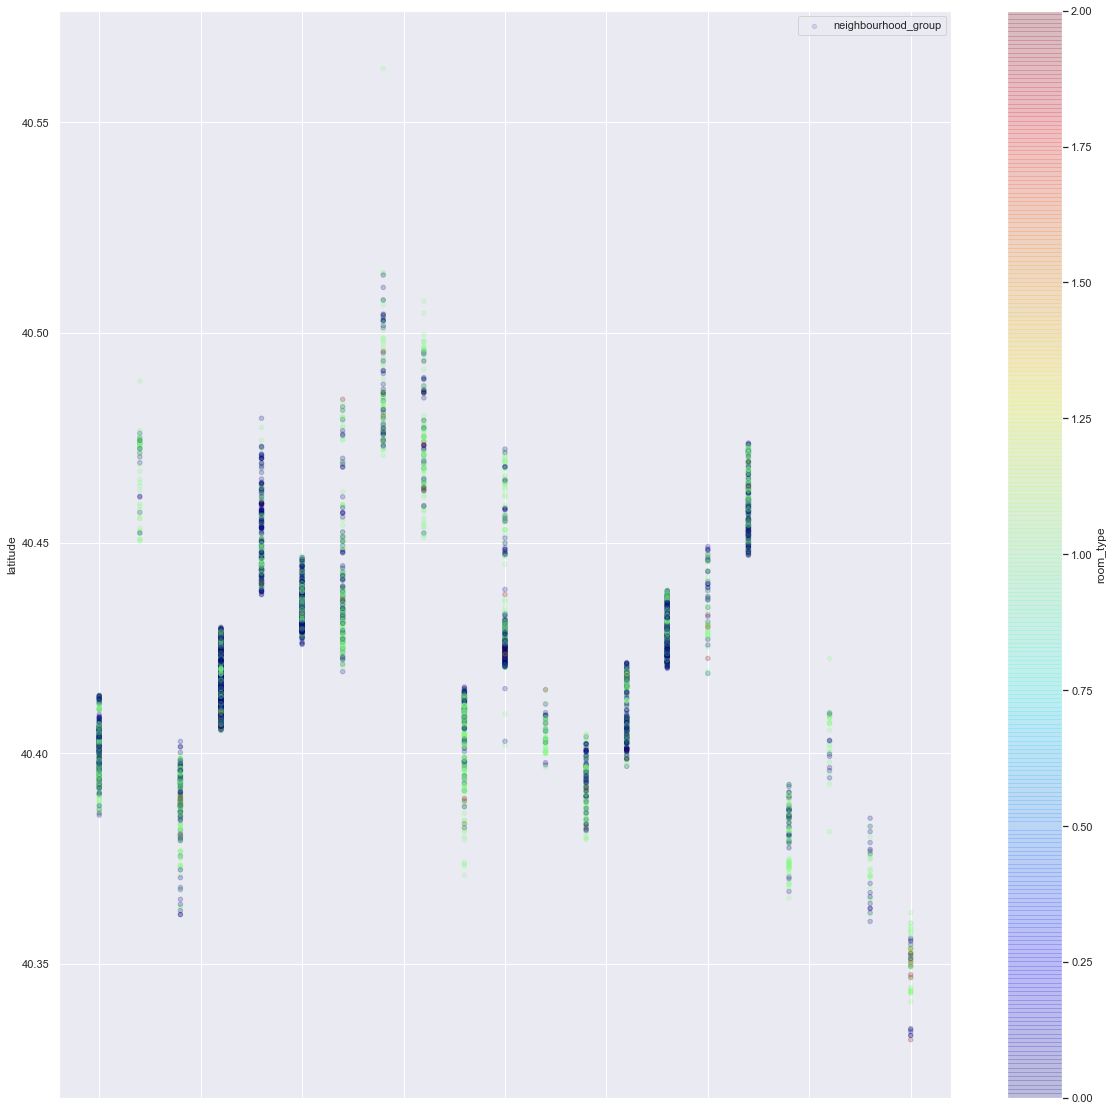

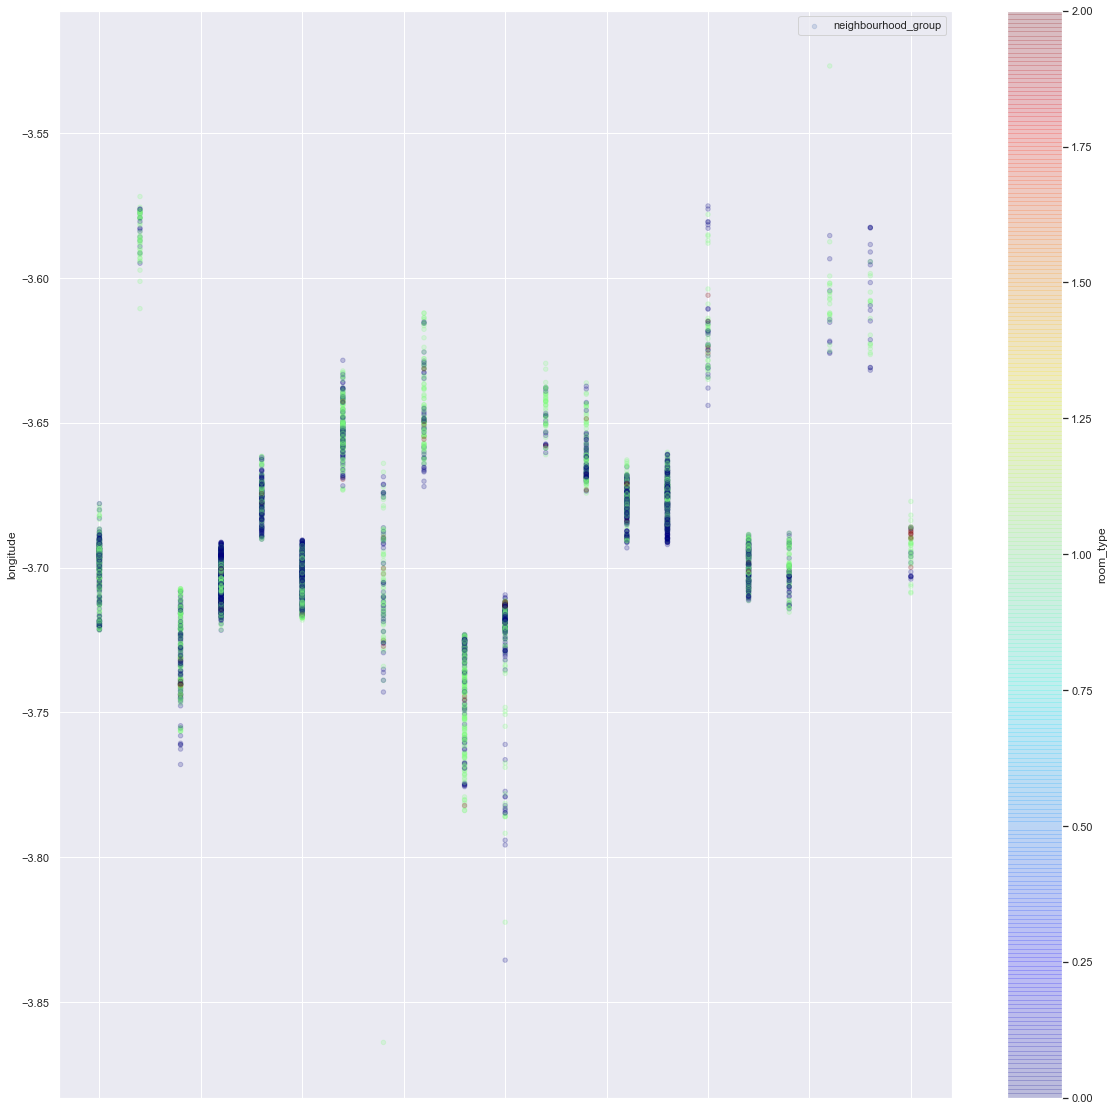

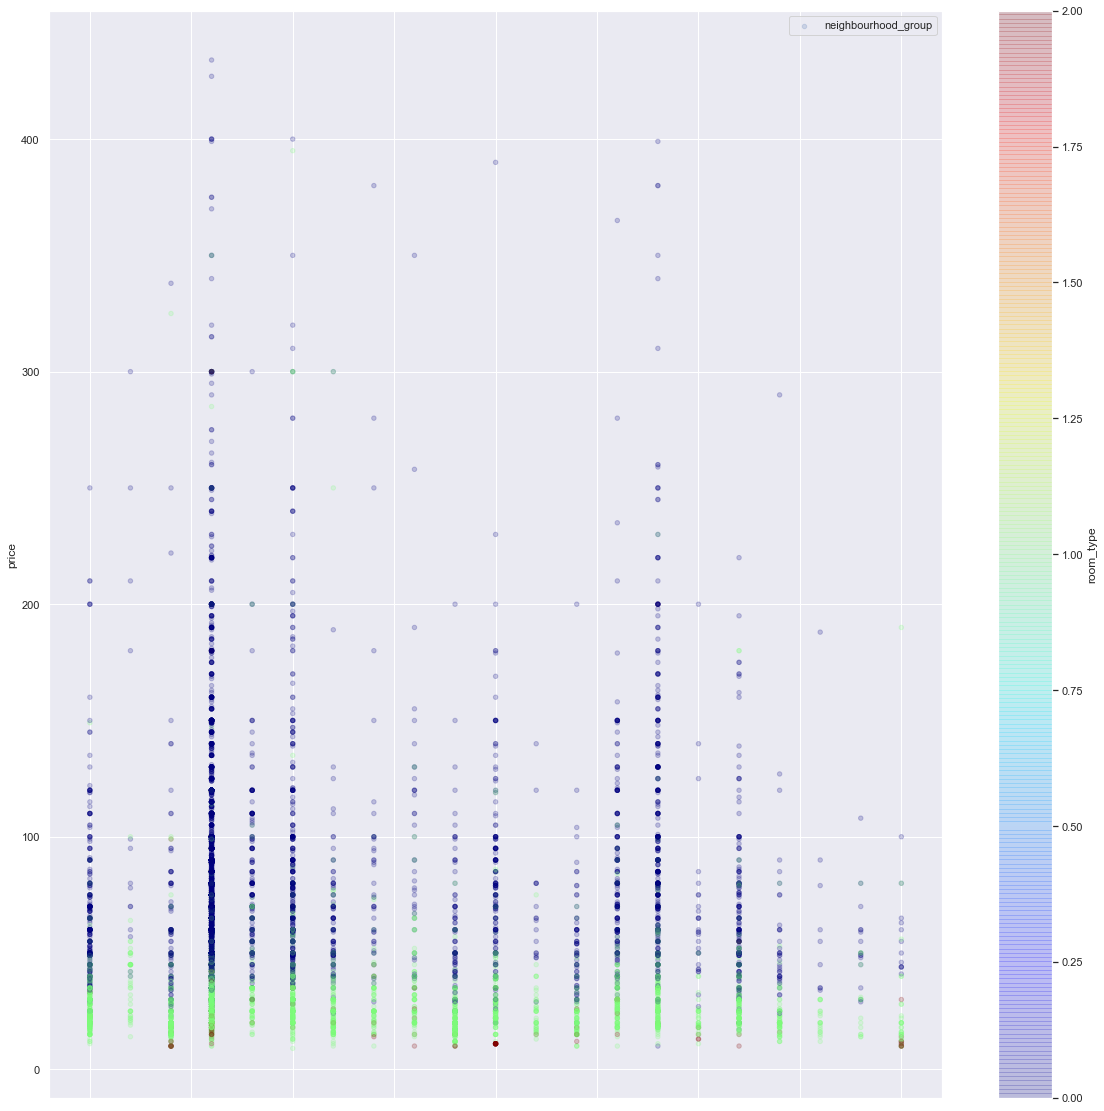

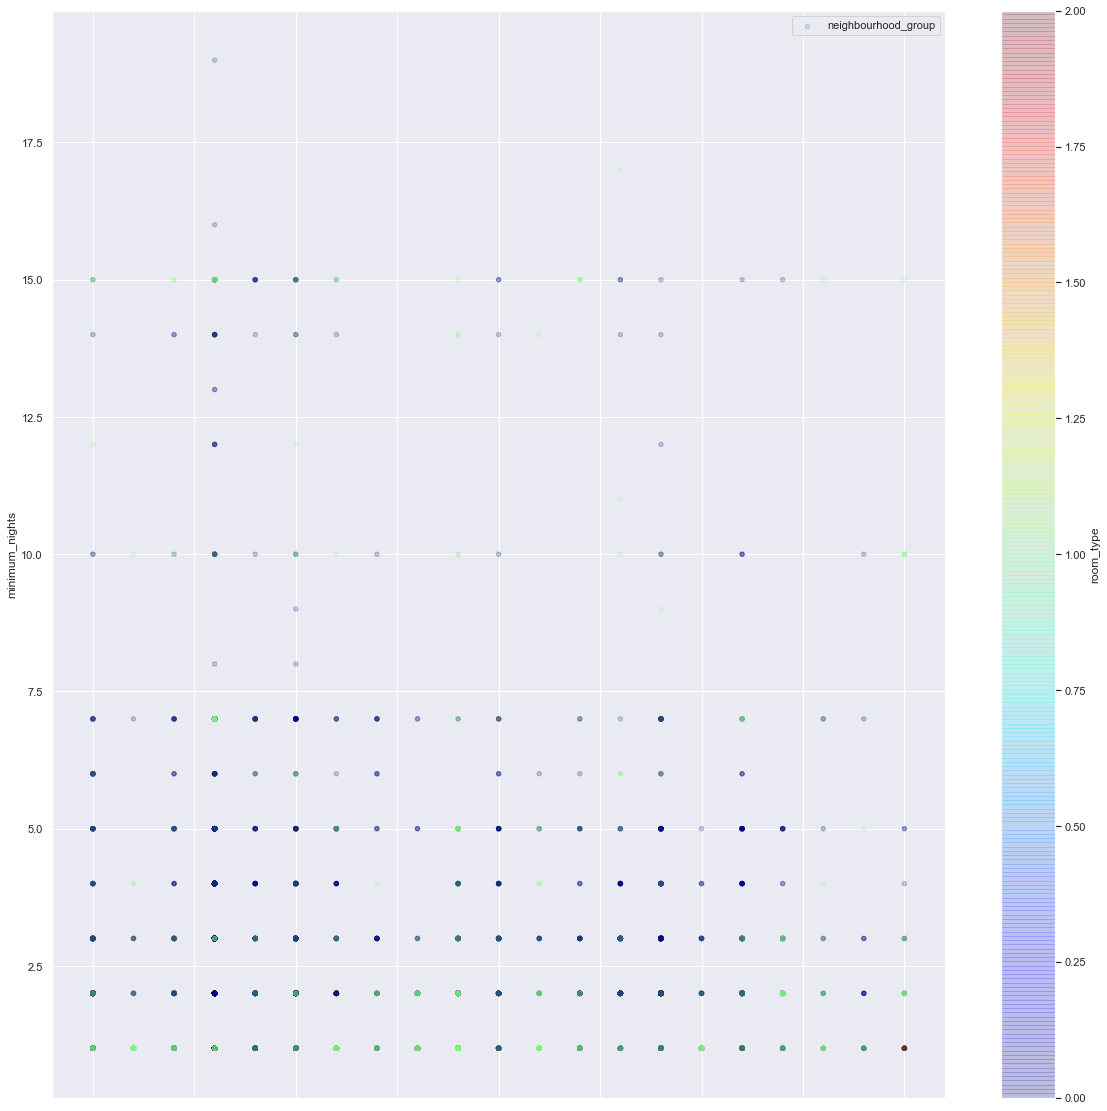

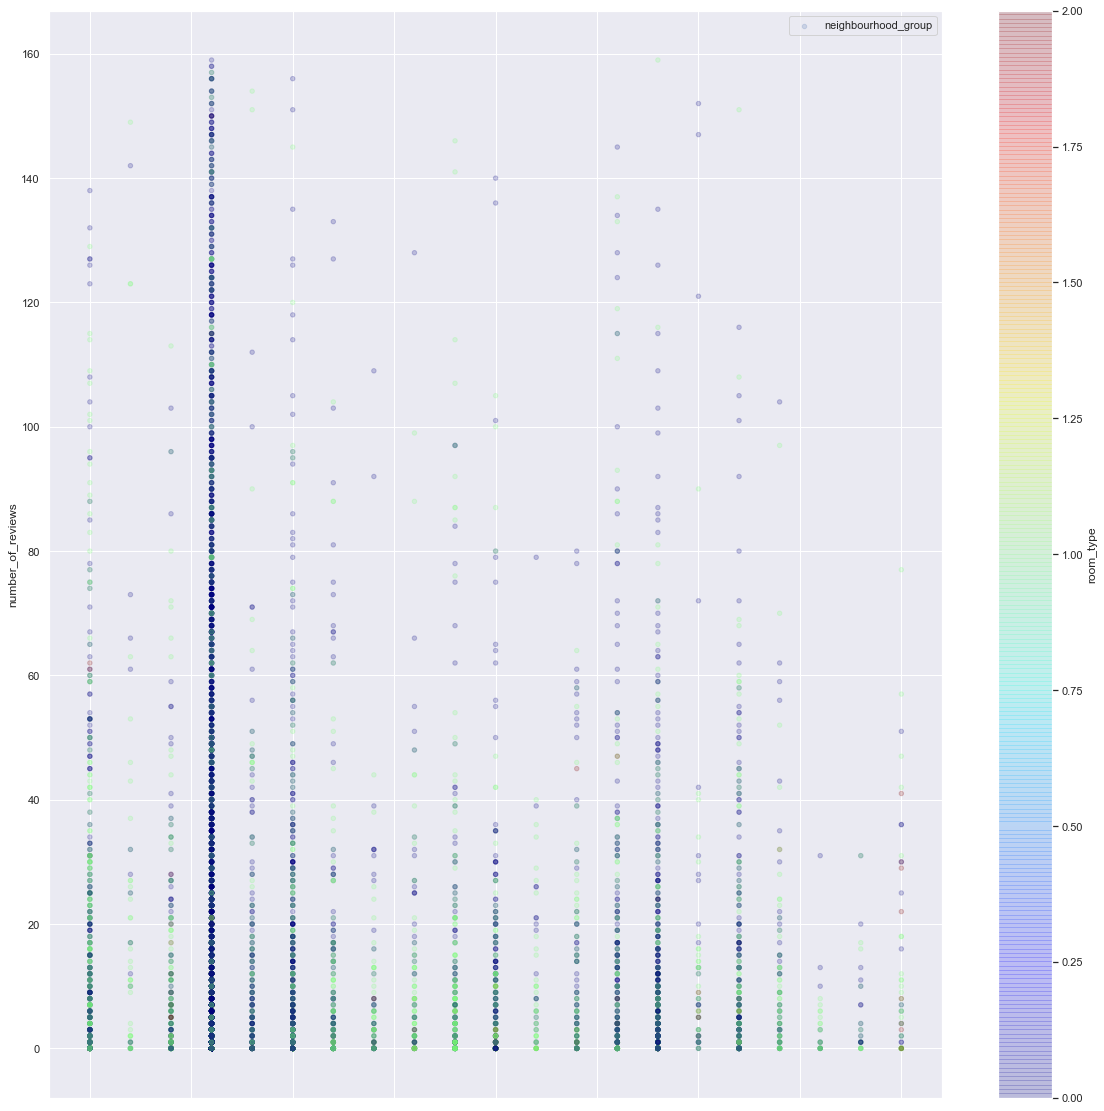

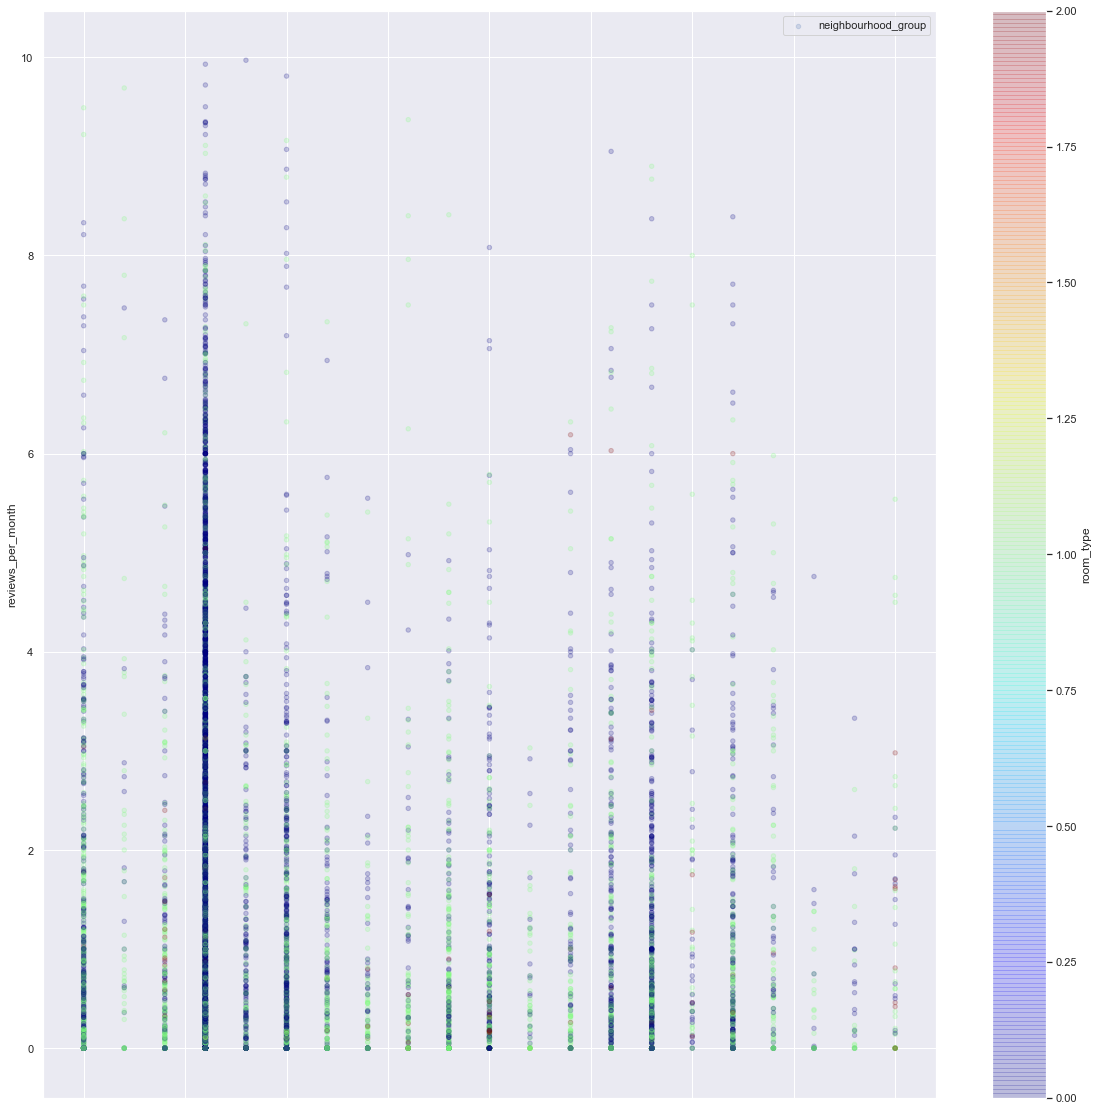

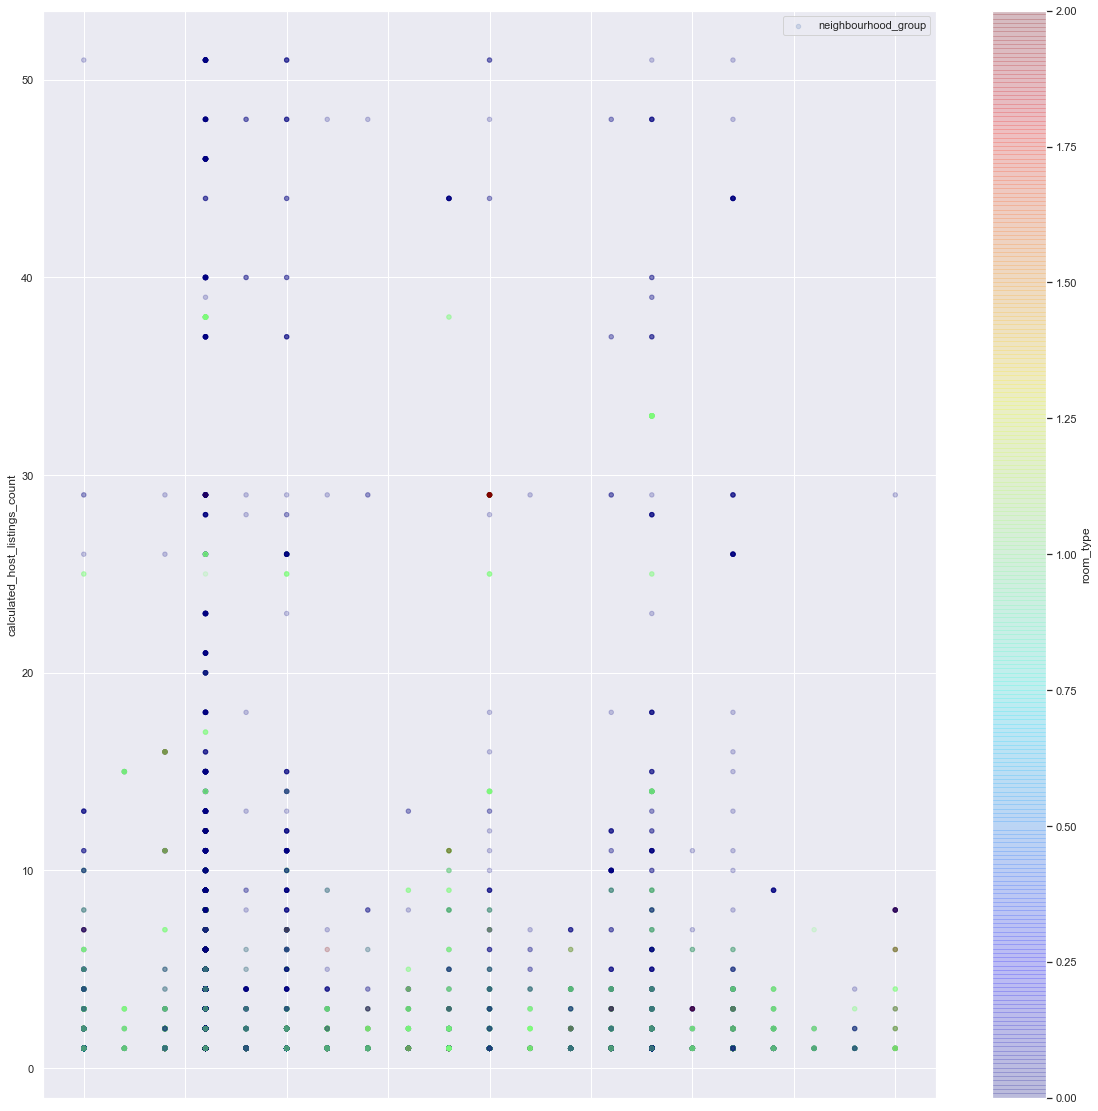

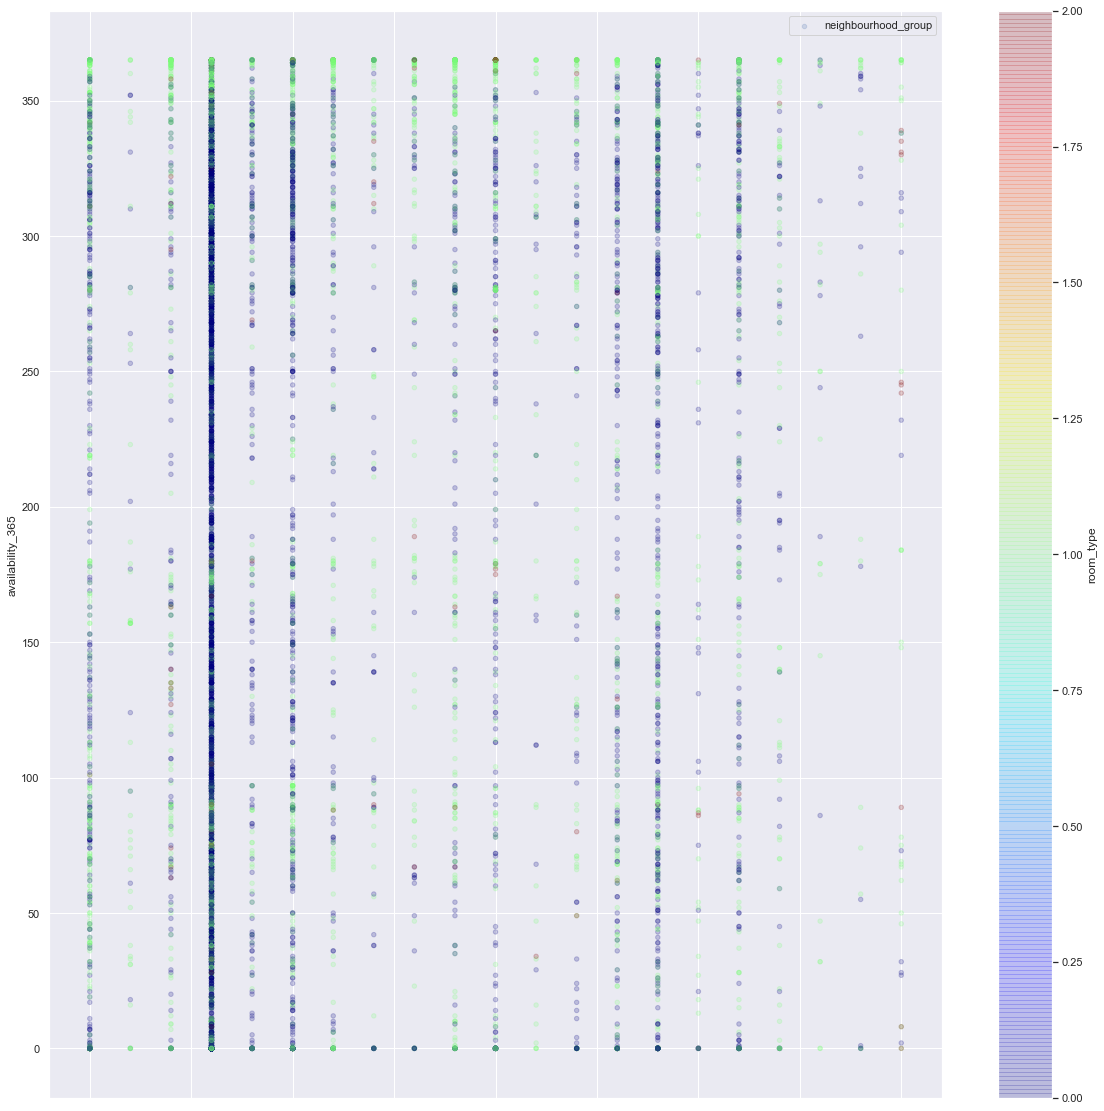

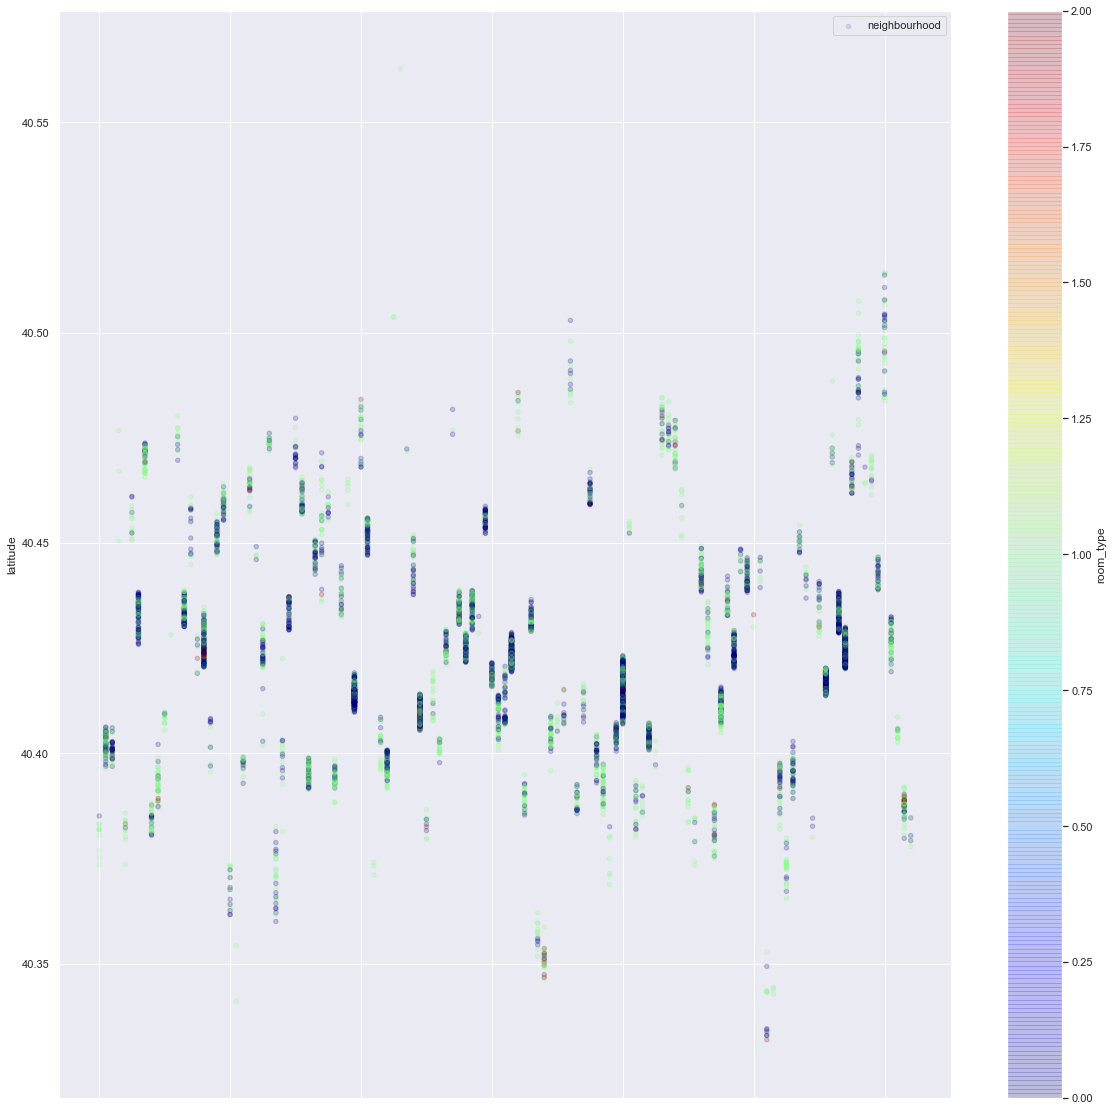

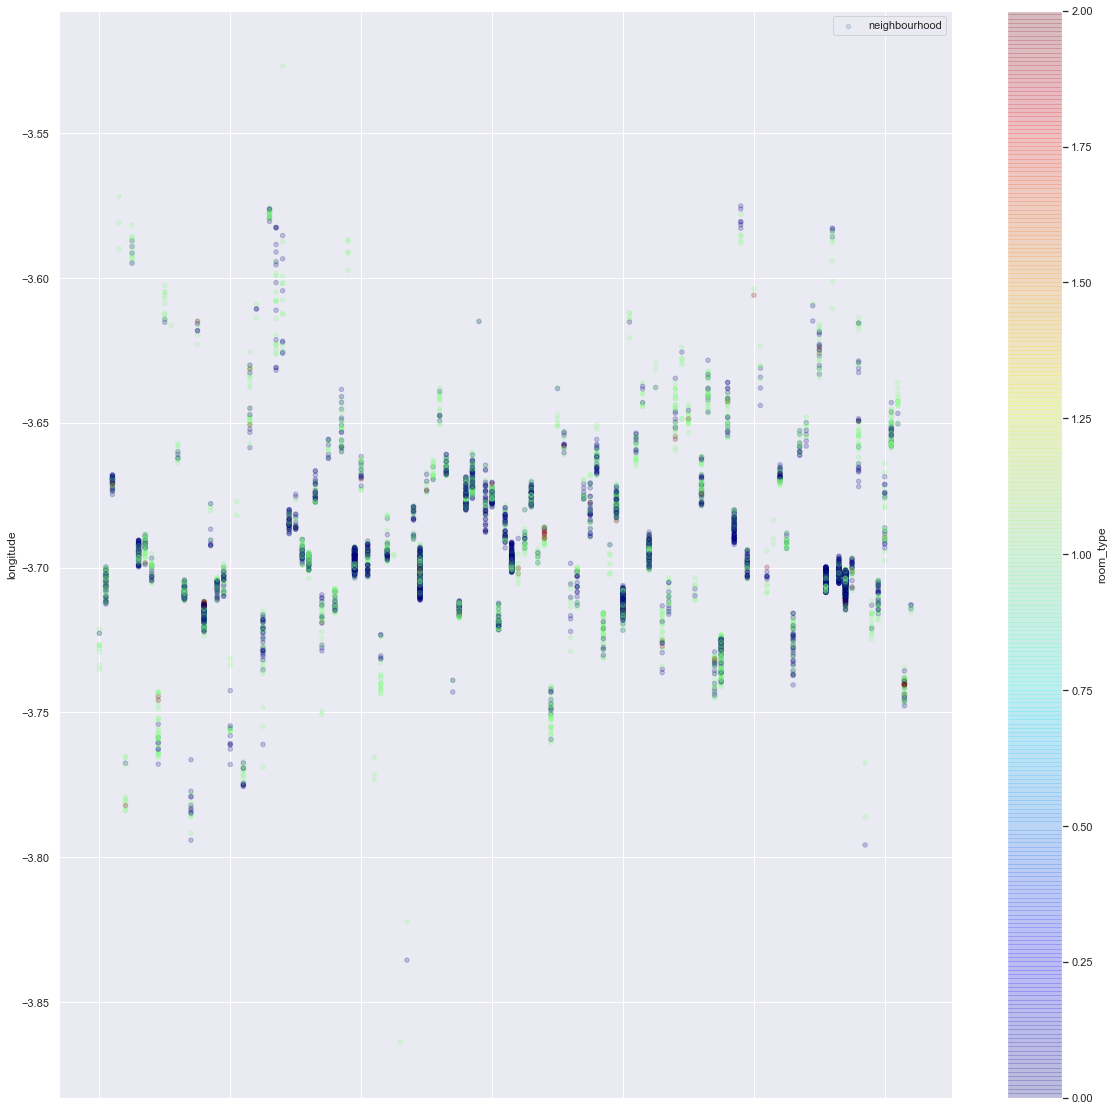

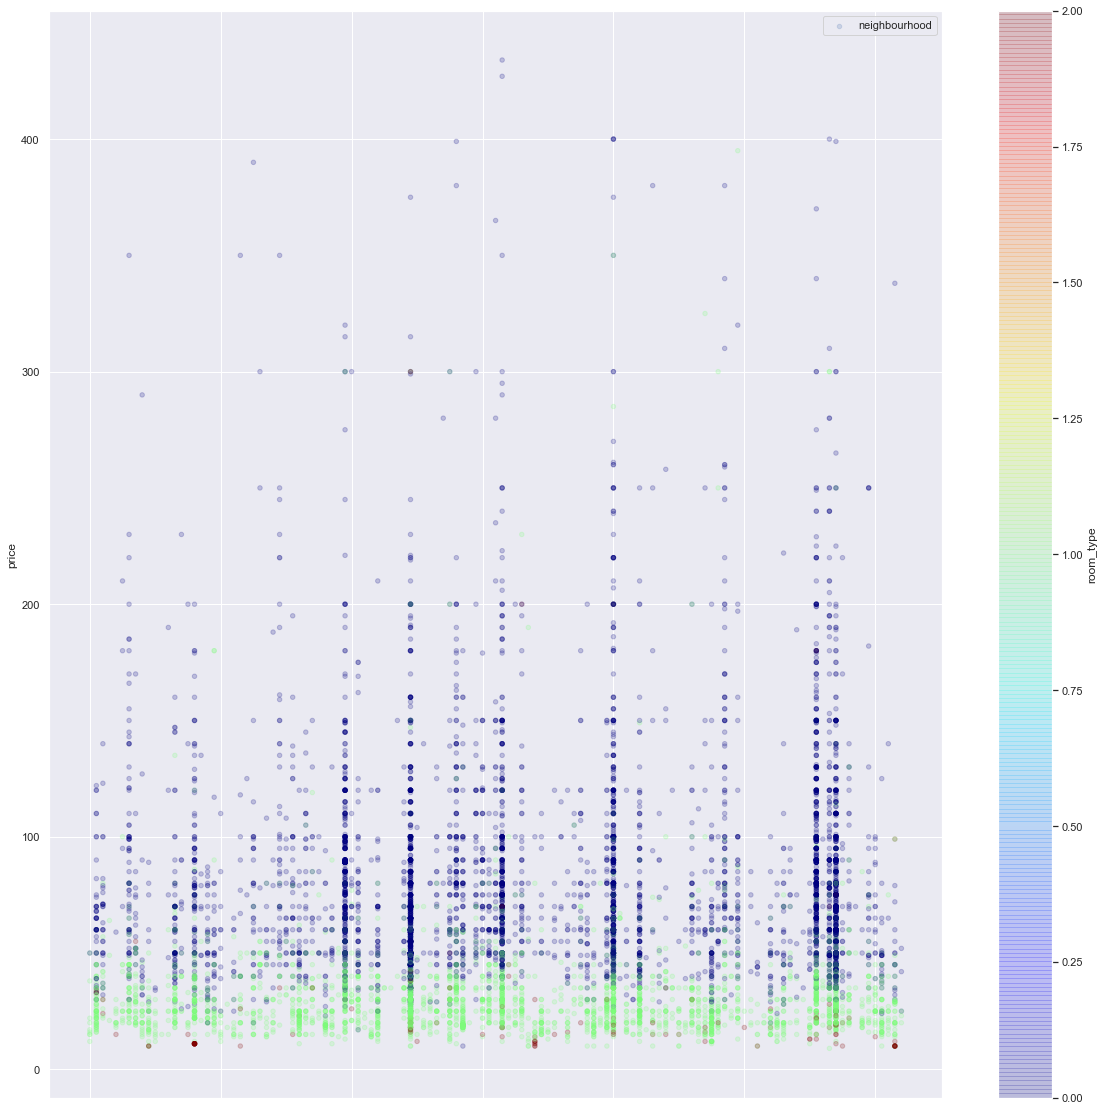

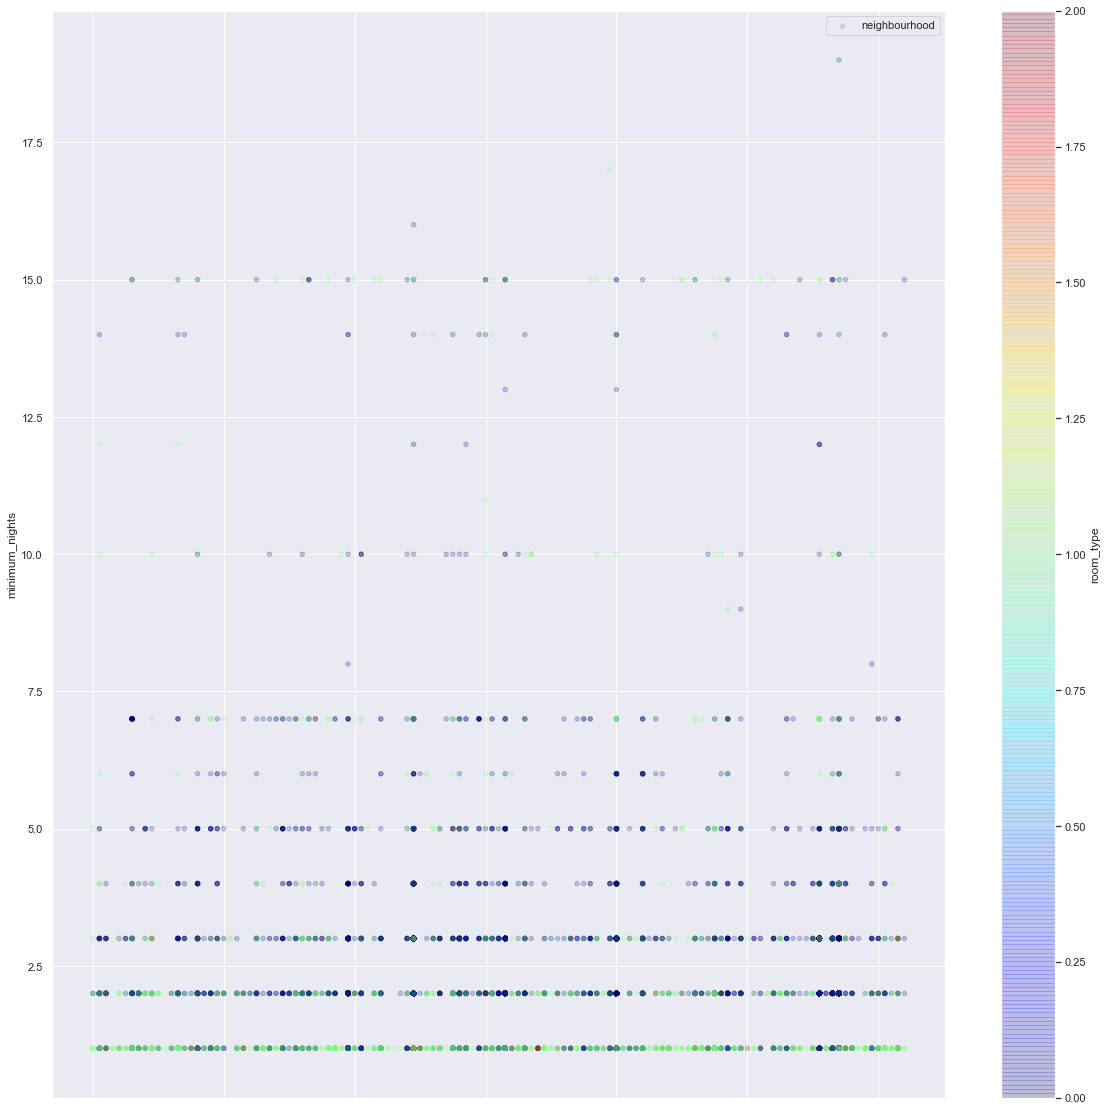

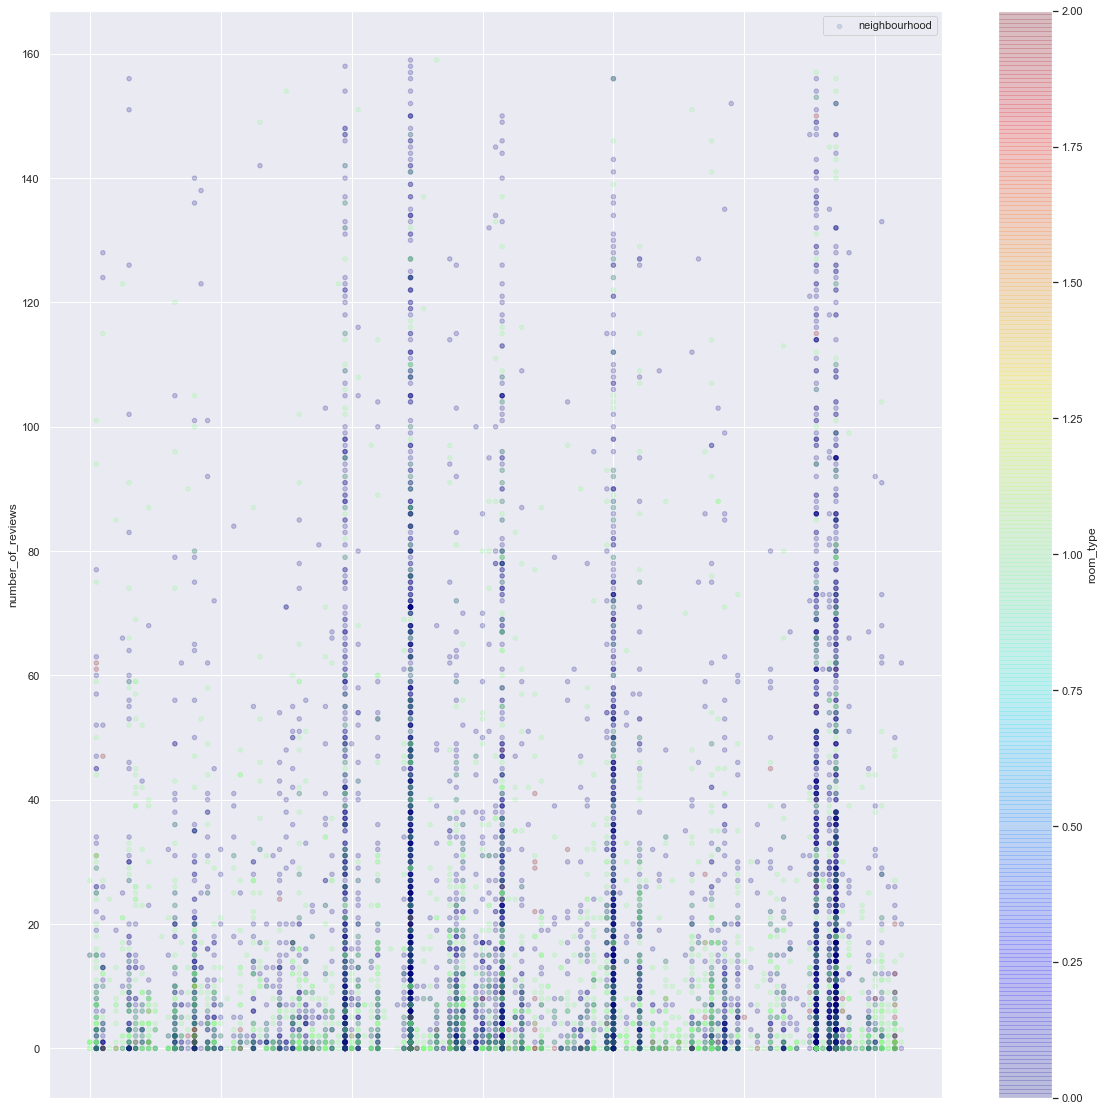

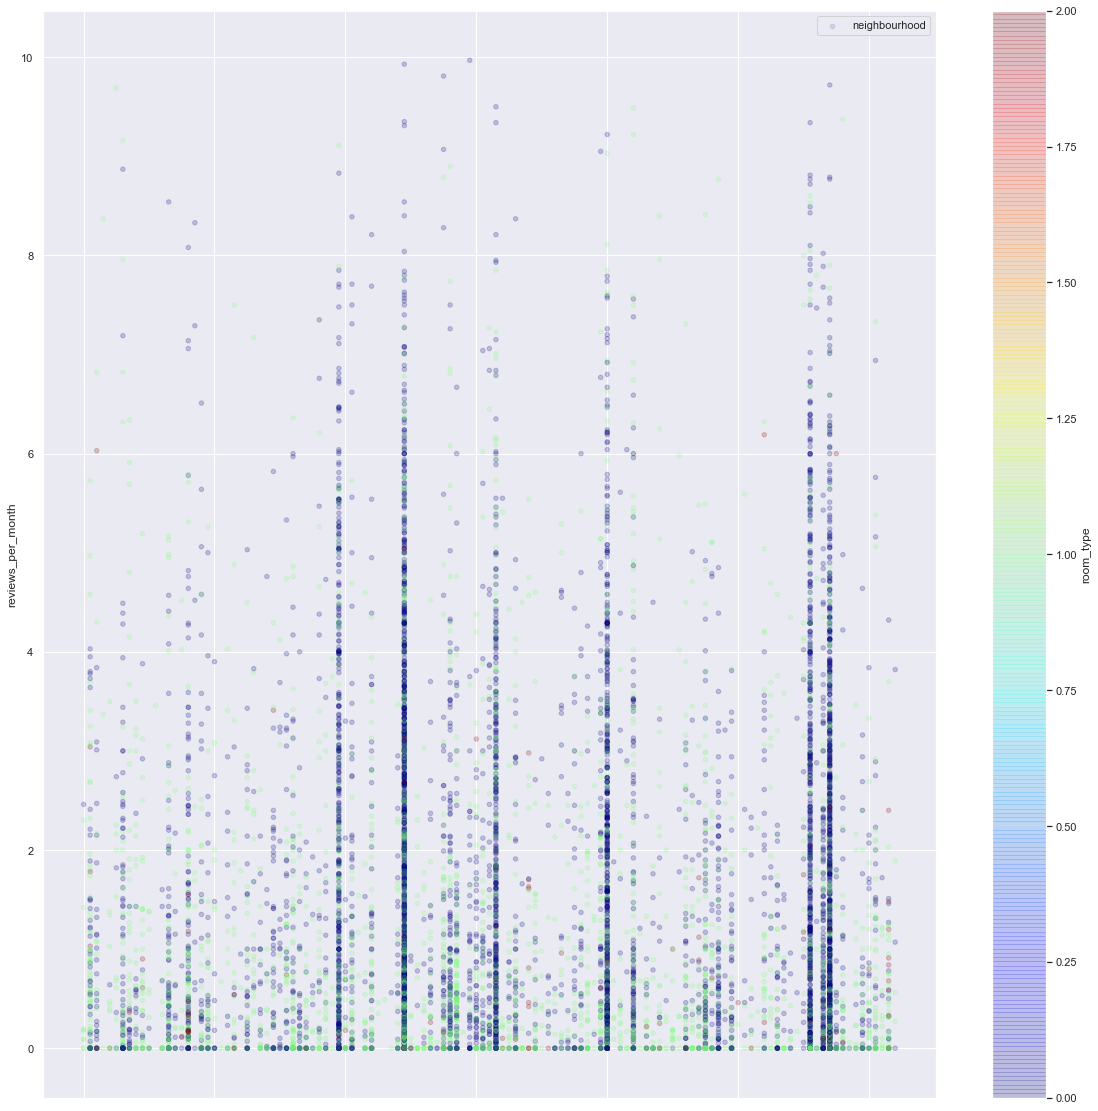

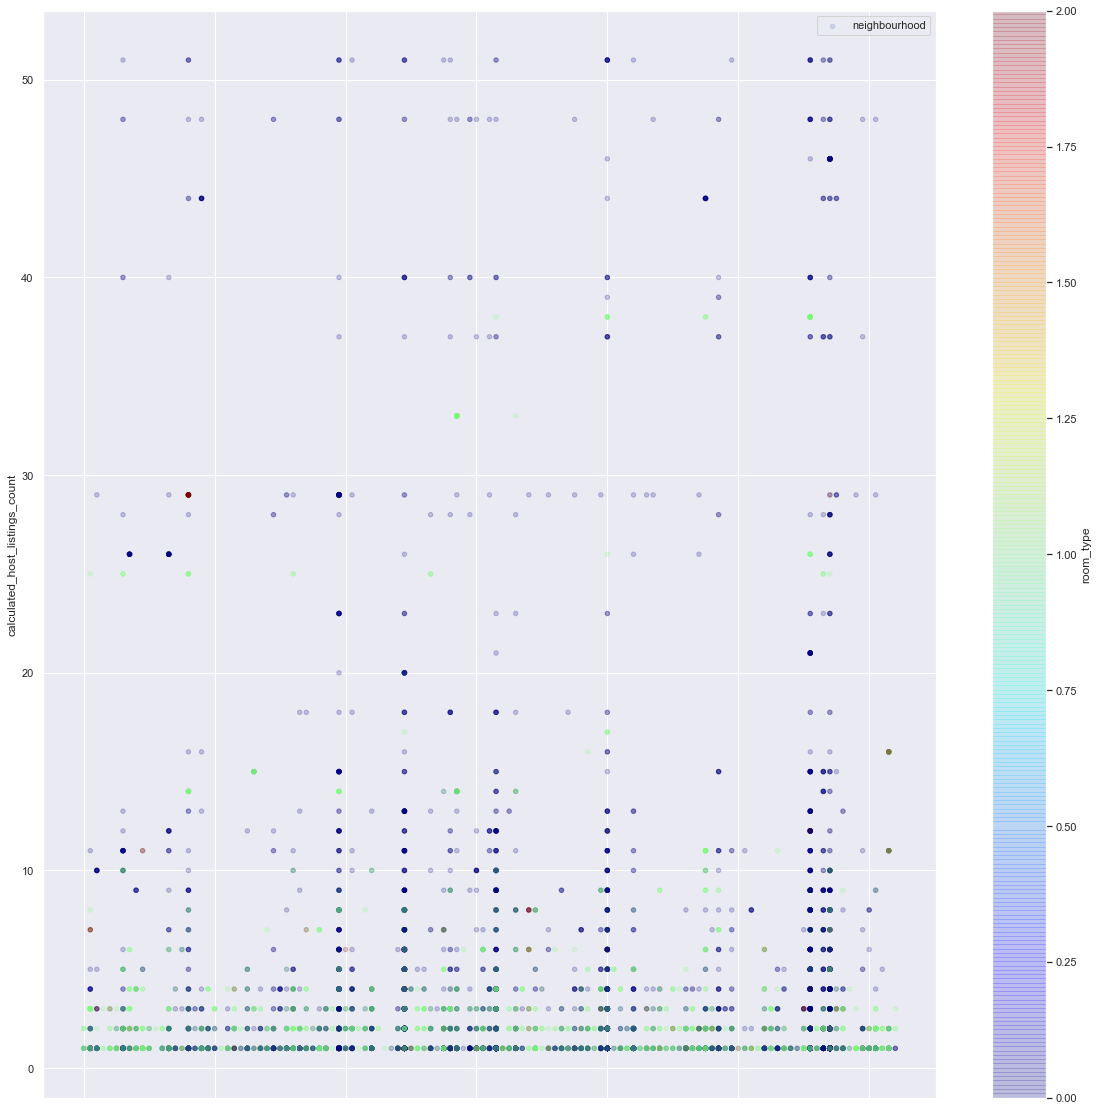

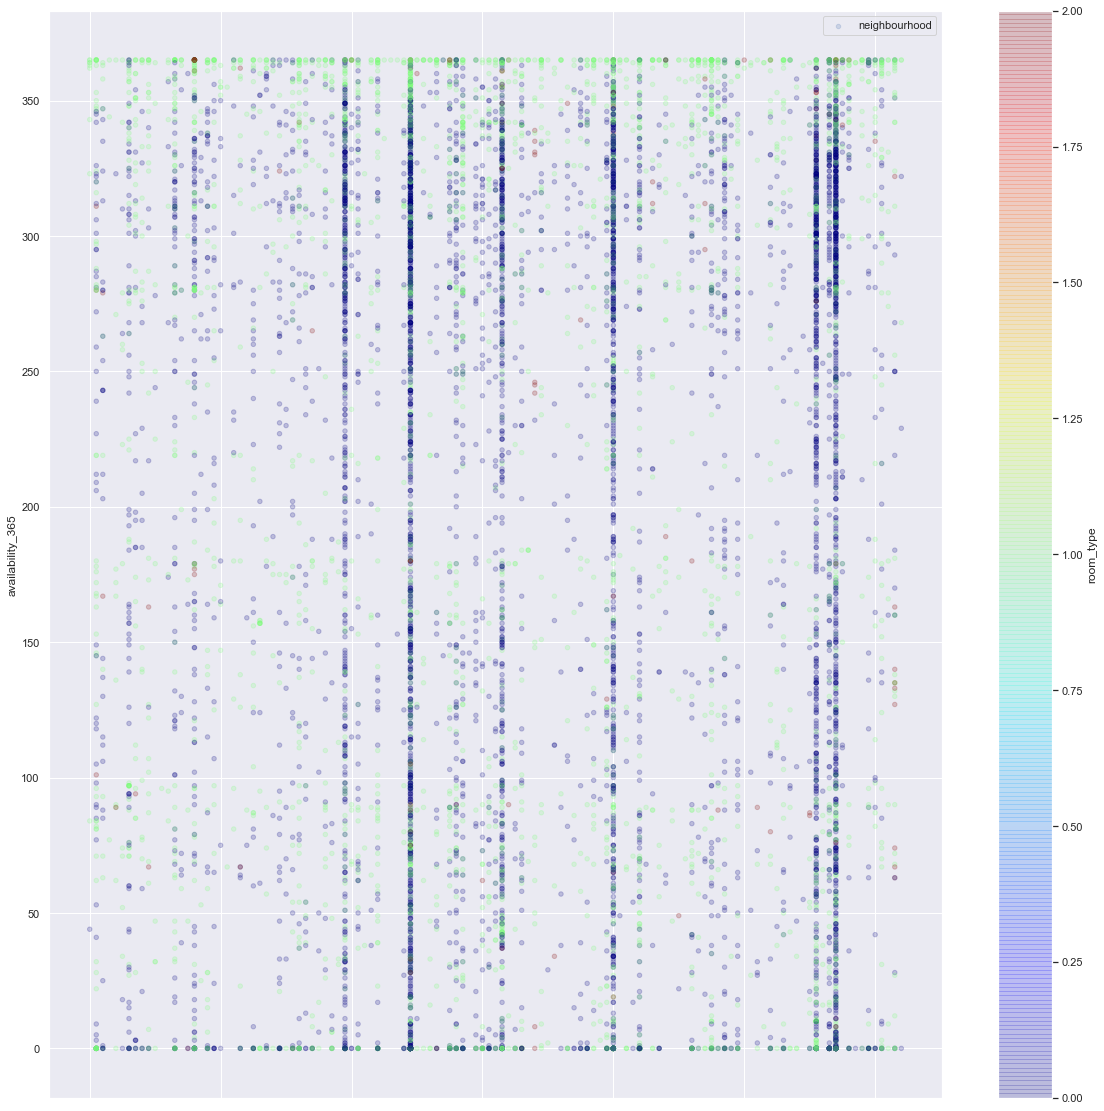

In [61]:
scatter_plot(ord_train, x_cat_train.columns, x_num_train.columns, y_train.columns[0])

Conclusiones:

Latitude y longitude parece que muestran cierta separación por barrio de los 2 grandes grupos de room_type. También se ve que en ciertos barrios predomina uno de los 2 grupos mas grandes. El grupo minoritario (Shared Room) no parece estar separado de forma significativa, lo que hará muy dificil su estimación.

La columna mas prometedora es price. Se ve una separación clara de los room_type.










In [74]:
# Nos va a dar mas información acerca de los datos del training set.
#pandas_profiling.ProfileReport(airbnb)

### Descartamos información.

neighbourhood_group y neighbourhood nos dan la misma información y visto que neighbourhood_group engloba los neighbourhood, nos vamos a quedar sólo con el primero.

Vamos a crear un pipeline para procesar los datos. room_type lo transformaremos a numérico con el OrdinalEncoder, para neighbourhood_group usaremos el OneHotEncoder y para los datos numéricos los escalaremos con el MinMaxScaler.

In [63]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

label = ["room_type"]
cat_attribs = ["neighbourhood_group"]
num_attribs = ["latitude","longitude","price","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]

full_pipeline = ColumnTransformer([
    ('label', OrdinalEncoder(), label),
    ('num', MinMaxScaler(), num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

In [64]:
train_prep = train_set.drop("neighbourhood", axis=1, inplace=False)[["room_type","latitude","longitude","price","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365","neighbourhood_group"]]
train_out = full_pipeline.fit_transform(train_prep)

In [65]:
categories = full_pipeline.named_transformers_.cat.categories_
categories = [*categories[0]]

In [68]:
train_prep_pline = pd.DataFrame(train_out, columns=[*label, *num_attribs, *categories])
x_train_prep = train_prep_pline[[*num_attribs, *categories]]
y_train_prep = train_prep_pline[label]

### Naive Bayes - GaussianNB

In [70]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score

gaus_naive_bayes_model = GaussianNB()
multi_naive_bayes_model = MultinomialNB()

In [71]:
gaus_naive_bayes_scores = cross_val_score(gaus_naive_bayes_model, x_train_prep, y_train.values.ravel(), cv=10, scoring="accuracy")
gaus_naive_bayes_scores.min()

0.056745182012847964

In [104]:
gaus_naive_bayes_model.fit(x_train_prep, y_train.values.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [105]:
#Saving model
gaus_path = os.path.join("models","gaus_naive_bayes_model.pkl")
joblib.dump(gaus_naive_bayes_model, gaus_path)

['models/gaus_naive_bayes_model.pkl']

In [77]:
num_gaus_naive_bayes_scores = cross_val_score(gaus_naive_bayes_model, x_train_prep[[*num_attribs]], y_train.values.ravel(), cv=10,scoring="accuracy")
num_gaus_naive_bayes_scores.min()

0.7569593147751607

In [130]:
gaus_naive_bayes_model.fit(x_train_prep[[*num_attribs]], y_train.values.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [131]:
#Saving model
num_gaus_path = os.path.join("models","num_gaus_naive_bayes_model.pkl")
joblib.dump(gaus_naive_bayes_model, num_gaus_path)

['models/num_gaus_naive_bayes_model.pkl']

No parece que el modelo se comporte muy bien con los datos categóricos. Como se puede ver los mejores resultados aparecen cuando quitamos la información de neighbourhood.

### Naive Bayes - MultinomialNB

In [73]:
multi_naive_bayes_scores = cross_val_score(multi_naive_bayes_model, x_train_prep, y_train.values.ravel(), cv=10,scoring="accuracy")
multi_naive_bayes_scores.min()

0.6263383297644539

In [135]:
multi_naive_bayes_model.fit(x_train_prep, y_train.values.ravel())

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [136]:
#Saving model
multi_path = os.path.join("models","multi_naive_bayes_model.pkl")
joblib.dump(multi_naive_bayes_model, multi_path)

['models/multi_naive_bayes_model.pkl']

Este modelo tiene un rendimiento superior al de Gaus, incluso con las columnas categoricas. 

## KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors' : np.arange(1,20),
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
grid_res = grid.fit(x_train_prep, y_train.values.ravel())
grid_res.best_params_
#{'algorithm': 'auto', 'n_neighbors': 6}

{'algorithm': 'auto', 'n_neighbors': 6}

GridSearch nos recomienda utilizar K=6, pero como tenemos 3 clases de room_type, no es recomendable que k sea un multiplo de 3. Si utilizamos k=6, podría darse el caso que de los 6 neighbors, 2 fuera de cada clase y el resultado quedase empatado. Probamos de nuevo sin los multiplos de 3.

In [53]:
param_grid = {
    'n_neighbors' : [1,2,4,5,7,8,10,11,13,14,16,17,19,20],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10)
grid_res = grid.fit(x_train_prep, y_train.values.ravel())
grid_res.best_params_
#{'algorithm': 'auto', 'n_neighbors': 8}

{'algorithm': 'auto', 'n_neighbors': 8}

In [87]:
k = 8
knn_model = KNeighborsClassifier(n_neighbors=k, algorithm="auto")
knn_score = cross_val_score(knn_model, x_train_prep, y_train.values.ravel(), cv=10).min()
print(knn_score)

knn_model.fit(x_train_prep, y_train.values.ravel())
knn_predict = knn_model.predict(x_train_prep)

confusion_matrix(y_train, knn_predict)

0.7863247863247863


array([[5195,  377,    2],
       [ 805, 2821,    4],
       [  28,   97,   17]])

In [88]:
#Saving model
knn_path = os.path.join("models","knn_model.pkl")
joblib.dump(knn_model, knn_path)

['models/knn_model.pkl']

Este algoritmo nos da una accuracy de 0.78, que es mejor que el resultado de Naive Bayes. Sin embargo, analizando la confusion matrix vemos que para la 3era categoria ("shared Room"), solo acierta 17 veces y que falla mas de 100 veces. En el caso de la segunda categoría, falla 1/3 de las veces.

# DecisionTree

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [56]:
param_grid = {
    'max_leaf_nodes' : np.arange(2,51),
    'min_samples_split' : np.arange(2,7),
    'max_depth' : np.arange(1,21),
    'class_weight' : ['balanced']
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)
grid_res = grid.fit(x_train_prep, y_train.values.ravel())
grid_res.best_params_
#{'max_depth': 10, 'max_{'class_weight': 'balanced', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2}leaf_nodes': 34, 'min_samples_split': 2}

{'class_weight': 'balanced',
 'max_depth': 2,
 'max_leaf_nodes': 4,
 'min_samples_split': 2}

In [92]:
dtree_model = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4, min_samples_split=2, 
                                     random_state=42, 
                                     class_weight="balanced")
cross_val_score(dtree_model, x_train_prep, y_train, cv=10).min()

0.7944325481798715

In [96]:
from sklearn.tree import export_graphviz

dtree_model.fit(x_train_prep, y_train)
export_graphviz(dtree_model, out_file="dtree.dot", feature_names=x_train_prep.columns, class_names=y_train["room_type"].unique(), rounded=True, filled=True)

Analizamos el grafo generado.

In [76]:
! dot -Tpng dtree.dot -o dtree.png

In [77]:
dtree_predict = dtree_model.predict(x_train_prep)
confusion_matrix(y_train, dtree_predict)

array([[4964,  608,    2],
       [ 430, 2802,  398],
       [   8,   60,   74]])

Este es el mejor algoritmo de los 3, presenta una accuracy del 79% y, analizando la confusion matrix, acierta en mas medida para la categoría shared room.

In [97]:
#Saving model
dtree_path = os.path.join("models","dtree_model.pkl")
joblib.dump(dtree_model, dtree_path)

['models/dtree_model.pkl']

## Cargamos el test set

In [113]:
test_set = pd.read_csv(cleaned_test_path)

In [114]:
aux = test_set.drop("neighbourhood", axis=1, inplace=False)[["room_type","latitude","longitude","price","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365","neighbourhood_group"]]
test_set_prep = full_pipeline.fit_transform(aux)
test_set_prep

array([[0.        , 0.54905845, 0.29995719, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.50634956, 0.35620207, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.49852173, 0.39562542, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.57098114, 0.38049409, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.36644077, 0.55392838, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.48773384, 0.37924241, ..., 0.        , 0.        ,
        0.        ]])

In [115]:
categories = full_pipeline.named_transformers_.cat.categories_
categories = [*categories[0]]

In [124]:
test_prep_pline = pd.DataFrame(test_set_prep, columns=[*label, *num_attribs, *categories])
x_test_prep = test_prep_pline[[*num_attribs, *categories]]
y_test_prep = test_prep_pline[label]

In [126]:
y_test = test_set["room_type"]

Cargamos los modelos entrenados.

In [137]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score

gaus_naive_bayes_model = joblib.load(gaus_path)
num_gaus_naive_bayes_model = joblib.load(num_gaus_path)
knn_model = joblib.load(knn_path)
dtree_model = joblib.load(dtree_path)

### Naive Bayes - GaussianNB

In [127]:
predict = gaus_naive_bayes_model.predict(x_test_prep)
confusion_matrix(y_test, predict)

array([[ 127,   38, 1221],
       [  52,   74,  780],
       [   1,    1,   33]])

In [142]:
predict = num_gaus_naive_bayes_model.predict(x_test_prep[[*num_attribs]])
confusion_matrix(y_test, predict)

array([[976, 392,  18],
       [119, 775,  12],
       [  6,  27,   2]])

### Naive Bayes - MultinomialNB

In [138]:
predict = multi_naive_bayes_model.predict(x_test_prep)
confusion_matrix(y_test, predict)

array([[1217,  169,    0],
       [ 538,  368,    0],
       [  21,   14,    0]])

## KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

In [139]:
predict = knn_model.predict(x_test_prep)
confusion_matrix(y_test, predict)

array([[1300,   85,    1],
       [ 323,  583,    0],
       [   8,   24,    3]])

# DecisionTree

In [6]:
from sklearn.tree import DecisionTreeClassifier

In [140]:
predict = dtree_model.predict(x_test_prep)
confusion_matrix(y_test, predict)

array([[1301,   83,    2],
       [ 214,  634,   58],
       [   3,   21,   11]])

## Conlusiones:
Analizando las confusion matrix de cada modelo vemos que todos los modelos tienen problemas categorizando los "shared room". Es sorprendente que el GaussianNB acierte 33 de los 35 shared rooms que tenemos en el set de test, sin embargo los resultados para las otras 2 categorías son muy malos.

El KNN funciona muy bien para la primera categoría, pero no obtiene buenos resultados para las otras 2. Posiblemente sea porque la primera categoría es la que mas registros tiene y, dado que los datos no estaban muy separados, la probabilidad de que los k-neighbours mas cercanos sean de la primera categoría es mas alta.

El DecisionTree es el que mejor resultado ha obtenido, pero de nuevo no es muy bueno encontrando la 3era categoría (shared rooms).


# Pruebas preliminares

Sección en la que he ido probando diferente maneras de analizar mi dataset y entender los datos. 

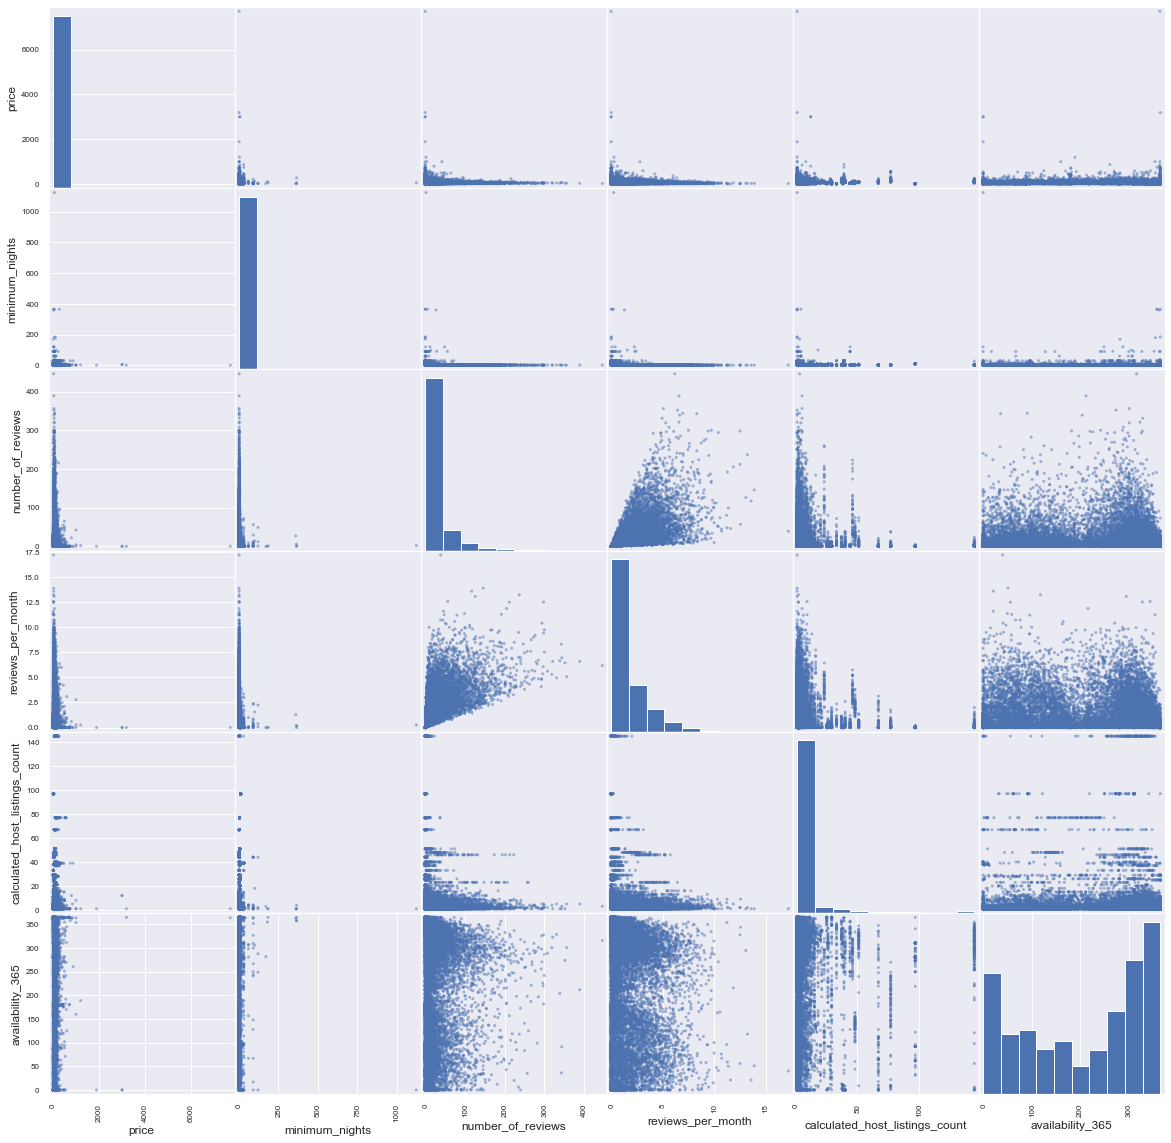

In [27]:
scatter_matrix(num_airbnb.drop(columns=["latitude","longitude"],axis=1,inplace=False), figsize=(20,20))
plt.show()

reviews_per_month y number_of_reviews tienen una relación entre ellas. Cuando una aumenta, aumenta la otra.

In [28]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
ordinal_y_train = ordinal_encoder.fit_transform(airbnb[["room_type"]])
ordinal_y_train_df = pd.DataFrame(ordinal_y_train)
ordinal_y_train_df

0
0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
...    ...
13316  1.0
13317  0.0
13318  0.0
13319  0.0
13320  0.0

[13321 rows x 1 columns]

In [29]:
ordinal_encoder.categories_

[array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)]

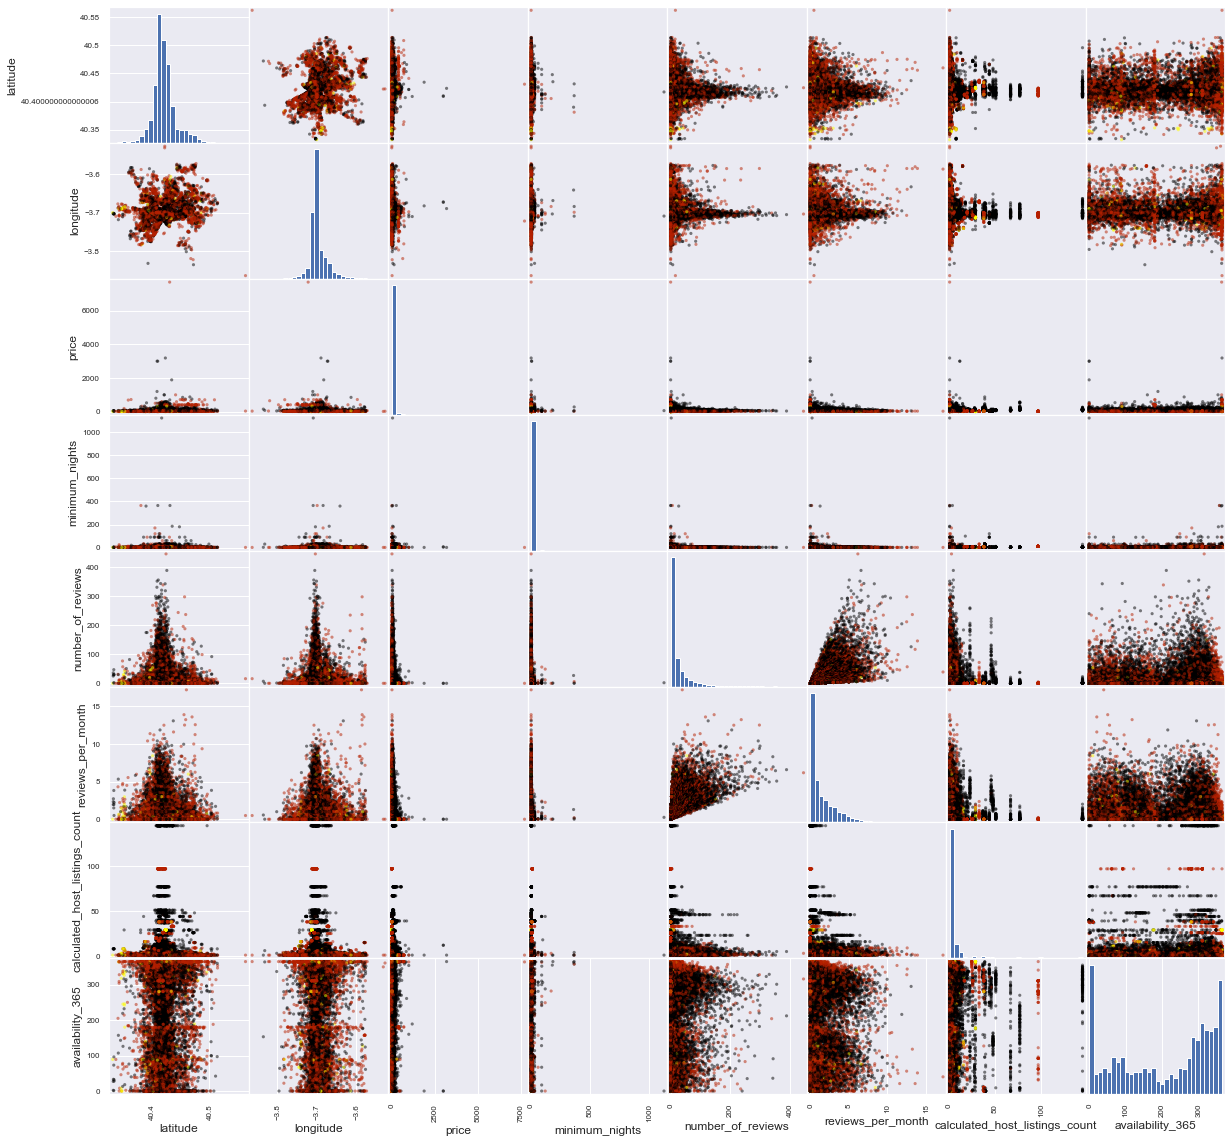

In [30]:
from matplotlib import cm

cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(num_airbnb, c = ordinal_y_train_df[0], marker = 'o', s=10, hist_kwds={'bins':30}, figsize=(20,20), cmap = cmap)

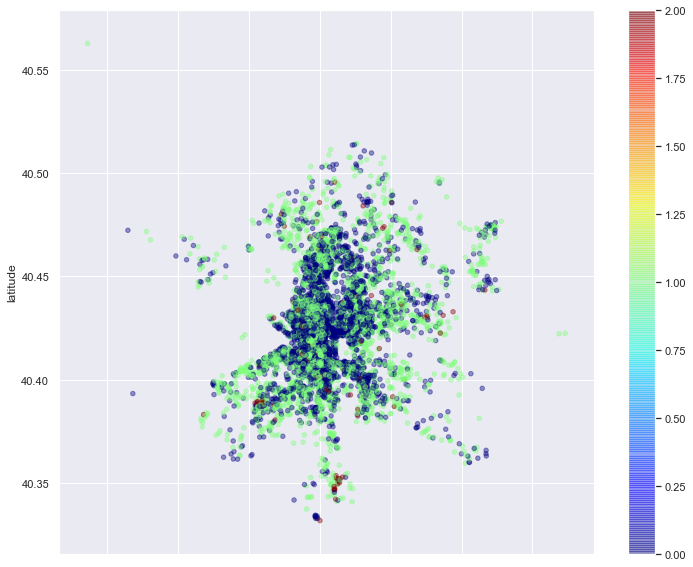

In [31]:
num_airbnb.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(12,10),
             c=ordinal_y_train_df[0], cmap=plt.get_cmap("jet"), colorbar=True
            )

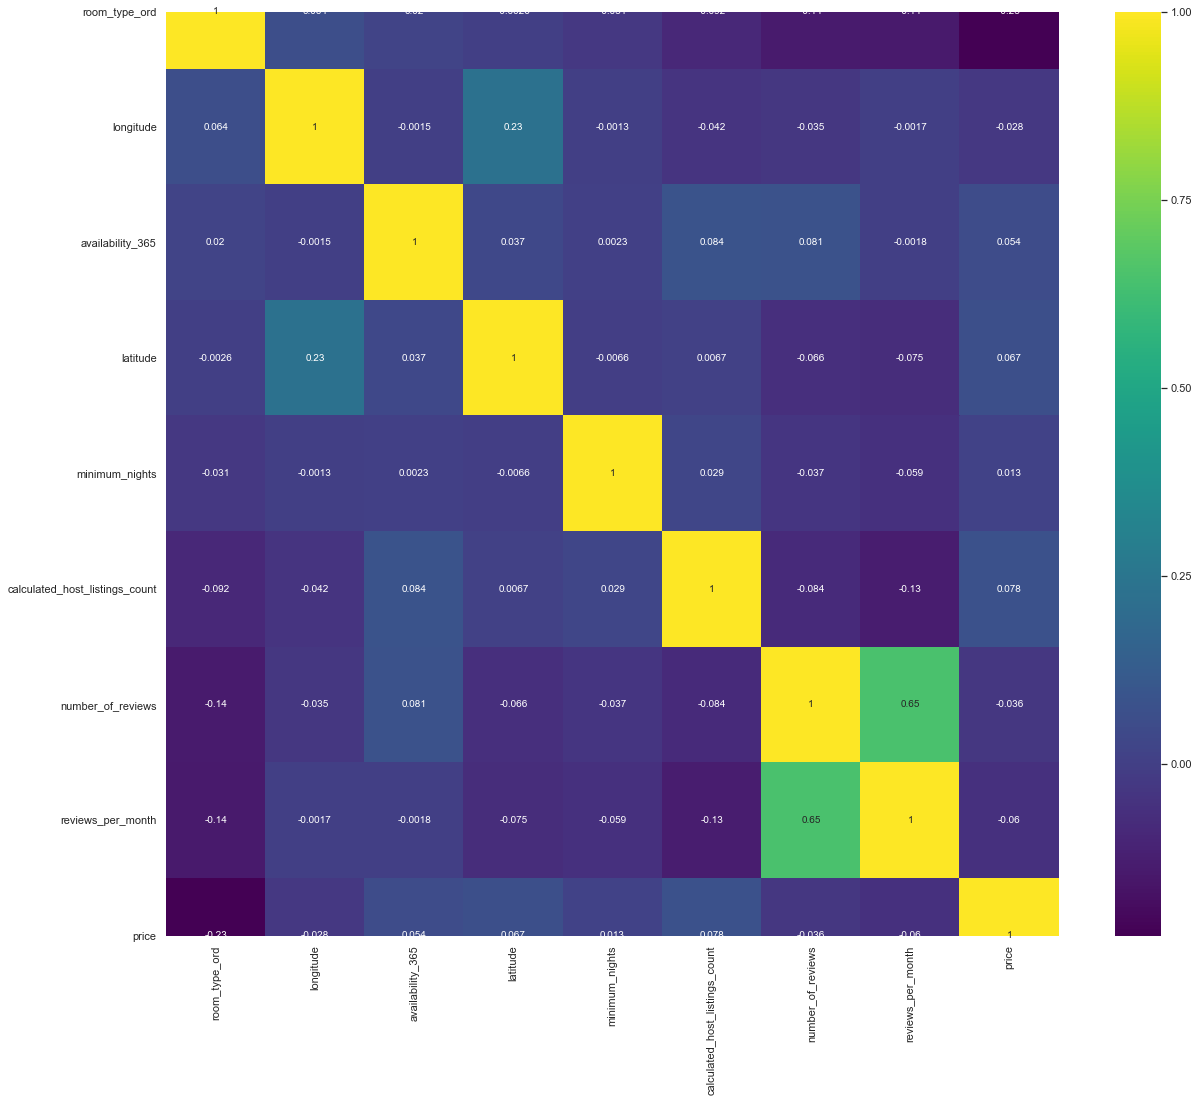

In [32]:
num_airbnb["room_type_ord"] = ordinal_y_train_df[0]
k = 12
cols = num_airbnb.corr().nlargest(12, 'room_type_ord')["room_type_ord"].index
cm = num_airbnb[cols].corr()
plt.figure(figsize=(20,17))
sns.heatmap(cm, annot=True, cmap='viridis')

In [33]:
num_airbnb.drop("neighbourhood",axis=1,inplace=False).groupby("neighbourhood_group").hist()

KeyError: "['neighbourhood'] not found in axis"

In [ ]:
airbnb[airbnb["room_type"] == "Entire home/apt"]["neighbourhood"].value_counts().plot(kind='barh', figsize=(20,17))

In [ ]:
airbnb[airbnb["room_type"] == "Private room"]["neighbourhood"].value_counts().plot(kind='barh', figsize=(20,17))

In [ ]:
airbnb[airbnb["room_type"] == "Shared room"]["neighbourhood"].value_counts().plot(kind='barh', figsize=(20,17))

# Estudio estadistico y limpieza de datos
1) Estudio estadístico de los datos<br/>
2) Contar Nº de registros por categoria de room_type  (Balanceo de clases) <br/>
3) limpieza de datos <br/>
4) Estudio de correlación <br/>

### 1)

In [ ]:
airbnb.head(10)

Comprobamos que los datos se han cargado correctamente y visualizamos nuestros datos por encima:

In [ ]:
airbnb.describe()

In [ ]:
airbnb.info()

In [ ]:
airbnb.hist(bins=50, figsize=(23,15))
plt.show()

# Conclusiones
No existen valores NULL en ninguna de las columnas -> Todas tienen 13321 registros.

neighbourhood_group, neighbourhood y room_type son features categóricas.

Se aprecia que varios atributos son tail-heavy. Tendremos que tratar este tema mas adelante.


# Categorias de label

In [ ]:
airbnb["room_type"].hist()

In [ ]:
airbnb["neighbourhood"].hist(figsize=(20,17), bins=60)

## Creamos test y train set

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Nota, he probado con neighbourhood, pero al tener categorias con menos de 2 valores, no podemos usar esta columna para stratificar. 
# Esto nos deja 2 opciones: 
# 1- Borrar los registros cuya categoría sólo tiene 1 registro. Pero perdemos registros valiosos.
# 2- Usar neighbourhood_group, que agrupa los neighbourhood y no tiene el mismo inconveniente.
for train_indices, test_indices in split.split(airbnb, airbnb["neighbourhood_group"]):
    strat_train_set = airbnb.loc[train_indices]
    strat_test_set = airbnb.loc[test_indices]

In [ ]:
test_path = os.path.join("sets","strat_test_set.csv")
#strat_test_set.to_csv(test_path, index=False)

In [ ]:
train_path = os.path.join("sets","strat_train_set.csv")
#strat_train_set.to_csv(train_path, index=False)

# Correlation matrix

In [ ]:
train_set = pd.read_csv(train_path)
y_train = train_set["room_type"]
#x_train = train_set.drop(["room_type","neighbourhood_group"], axis=1, inplace=False)
x_train = train_set.drop("room_type", axis=1, inplace=False)

In [ ]:
x_train.info()

Primero tenemos que convertir las categorias a numeros. Usaremos OneHotEncoder.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

label = ["room_type"]
cat_attribs = ["neighbourhood_group","neighbourhood"]
num_attribs = ["latitude","longitude","price","minimum_nights","number_of_reviews","reviews_per_month","calculated_host_listings_count","availability_365"]

full_pipeline = ColumnTransformer([
    ('label', OrdinalEncoder(), label),
    ('num', MinMaxScaler(), num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

In [ ]:
train_prep_out = full_pipeline.fit_transform(train_set)

In [ ]:
categories = full_pipeline.named_transformers_.cat.categories_
categories = [*categories[0], *categories[1]]

In [ ]:
train_prep   = pd.DataFrame(train_prep_out.toarray(), columns=[[*label, *num_attribs, *categories]])
x_train_prep = train_prep[[*num_attribs, *categories]]
y_train_prep = train_prep[label]

In [ ]:
y_train_prep

In [ ]:
train_prep

In [ ]:
train_set["room_type"] = ordinal_y_train_df[0]
k = 5
col = train_set.corr().nlargest(n=k, columns="room_type").index
cm = train_set[col].corr()
plt.figure(figsize=(20,14))
sns.heatmap(cm, annot=True, cmap='viridis')

In [ ]:
k = 12
cols = train_prep.corr().nlargest(12, 'room_type')["room_type"].index
cm = train_prep[cols].corr()
plt.figure(figsize=(20,17))
sns.heatmap(cm, annot=True, cmap='viridis')

In [ ]:
corr = train_prep.corr()[["room_type"]]
corr[abs(corr) > 0.1]
